In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import shap
from scipy.stats import ttest_ind, levene
from sklearn.preprocessing import MinMaxScaler
from numpy import inf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from bayes_opt import BayesianOptimization
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, ShuffleSplit
from sklearn.model_selection import train_test_split
import catboost as cb
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import time
import tensorflow.keras.initializers
import statistics
import tensorflow as tf
import tensorflow.keras
from sklearn import metrics
import sklearn
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)
pd.options.display.float_format = ('{:.3f}'.format)

# 목차
## 1. data processing
    1-1 데이터 열 추가
    1-2 결측치 처리
    1-3 파생변수 생성
    1-4 열 정리
## 2. 분리학습

## 3. 시각화

## 4. 변수 선정 by Stepwise &  Modeling

In [2]:
#코트라 제공 데이터
train_df = pd.read_csv('공모전데이터_분석용_KOTRA_0525.csv')
test_df = pd.read_csv('공모전데이터_예측용_KOTRA_0525.csv')

In [3]:
def insert_columns(df, YEAR):
    YEAR_before = YEAR - 1
    # HSCD 앞 두 자리로 TOP_HSCD 생성 
    df['TOP_HSCD'] = df['HSCD'] / 10000
    df['TOP_HSCD'] = df['TOP_HSCD'].astype('int')
    
    # GDP_real
    GDP_real = pd.read_excel('GDP_real.xlsx', engine = 'openpyxl').iloc[:,:4]
    GDP_real.columns = ['COUNTRYNM','GDP_real_2016','GDP_real_2017','GDP_real_2018']
    GDP_real_df = GDP_real[['COUNTRYNM',f'GDP_real_{YEAR}']]
    GDP_real_df.columns = ['COUNTRYNM','GDP_real']
    
    # Merge dataframe
    df = pd.merge(df, GDP_real_df, how = 'left', on = 'COUNTRYNM')
    
    # GDP_nominal
    GDP_nominal = pd.read_excel('GDP_nominal.xlsx', engine = 'openpyxl').iloc[:,:4]
    GDP_nominal.columns = ['COUNTRYNM','GDP_nominal_2016','GDP_nominal_2017','GDP_nominal_2018']
    GDP_nominal_df = GDP_nominal[['COUNTRYNM',f'GDP_nominal_{YEAR}']]
    GDP_nominal_df.columns = ['COUNTRYNM','GDP_nominal']
    
    # Merge dataframe
    df = pd.merge(df, GDP_nominal_df, how = 'left', on = 'COUNTRYNM')
    
    # GDP_Deflator 
    df['GDP_Deflator'] = df['GDP_nominal'] / df['GDP_real']
    
    # eco_growth
    eco_growth = pd.read_csv('eco_growth.csv').drop(columns = ['Country Code'])
    eco_growth.columns = ['COUNTRYNM','eco_growth_2017','eco_growth_2018']
    eco_growth_df = eco_growth[['COUNTRYNM',f'eco_growth_{YEAR}']]
    eco_growth_df.columns = ['COUNTRYNM','eco_growth']
    
    # Merge dataframe
    df = pd.merge(df, eco_growth_df, how = 'left', on = 'COUNTRYNM')
    
    # 국가별_기업규모별_수출
    export = pd.read_csv('국가별_기업규모별_수출.csv', encoding = 'cp949')
    export = export.drop(columns = ['코드값','국가명(국문)'])
    export_train = export[[f'{YEAR_before}_총수출', f'{YEAR_before}_중소기업',f'{YEAR_before}_중견기업',f'{YEAR_before}_대기업',
                          f'{YEAR_before}_기타',f'{YEAR}_총수출',f'{YEAR}_중소기업',f'{YEAR}_중견기업',f'{YEAR}_대기업',f'{YEAR}_기타','COUNTRYNM']]

    # 변수명 영문으로 변경 
    export_train.columns = [f'total_export_{YEAR_before}',f'small_firm_export_{YEAR_before}',f'mid_firm_export_{YEAR_before}',
                            f'big_firm_export_{YEAR_before}',f'etc_export_{YEAR_before}',f'total_export_{YEAR}',f'small_firm_export_{YEAR}',
                            f'mid_firm_export_{YEAR}',f'big_firm_export_{YEAR}',f'etc_export_{YEAR}','COUNTRYNM']
    # 증감률 변수 생성
    export_train['total_export_inc'] = export_train[f'total_export_{YEAR}'] - export_train[f'total_export_{YEAR_before}']
    export_train['small_firm_export_inc'] = export_train[f'small_firm_export_{YEAR}'] - export_train[f'small_firm_export_{YEAR_before}']
    export_train['mid_firm_export_inc'] = export_train[f'mid_firm_export_{YEAR}'] - export_train[f'mid_firm_export_{YEAR_before}']
    export_train['big_firm_export_inc'] = export_train[f'big_firm_export_{YEAR}'] - export_train[f'big_firm_export_{YEAR_before}']
    export_train['etc_export_inc'] = export_train[f'etc_export_{YEAR}'] - export_train[f'etc_export_{YEAR_before}']

    #증감률 생성 후 불필요한 변수 삭제 
    export_train = export_train.drop(columns = [f'total_export_{YEAR_before}', f'small_firm_export_{YEAR_before}',
                                                f'mid_firm_export_{YEAR_before}', f'big_firm_export_{YEAR_before}', f'etc_export_{YEAR_before}'])
    #변수명 변경 
    export_train.columns = ['total_export','small_firm_export','mid_firm_export','big_firm_export','etc_export','COUNTRYNM',
                            'total_export_inc','small_firm_export_inc','mid_firm_export_inc','big_firm_export_inc','etc_export_inc']
    # Merge dataframe
    df = pd.merge(df, export_train, how = 'left', on = 'COUNTRYNM')
    
    #각 국가의 대한국 무역수지 데이터 
    trade_balance = pd.read_csv('trade_balance_kor.csv', encoding = 'utf-8')
    trade_balance.columns = ['COUNTRYNM_kor','trade_balance_2016','trade_balance_2017','trade_balance_2018']

    # 형변환
    trade_balance['trade_balance_2016'] = trade_balance['trade_balance_2016'].str.replace(',', '').astype('float')
    trade_balance['trade_balance_2017'] = trade_balance['trade_balance_2017'].str.replace(',', '').astype('float')
    trade_balance['trade_balance_2018'] = trade_balance['trade_balance_2018'].str.replace(',', '').astype('float')

    #국가명, 국가코드 데이터 
    country = pd.read_csv('국가코드.csv', encoding = 'utf-8')
    country.columns = ['code','COUNTRYNM_kor','COUNTRYNM']

    #데이터프레임 결합 후 한국어 국가명 삭제 
    trade_balance = pd.merge(trade_balance, country[['COUNTRYNM','COUNTRYNM_kor']], how = 'left', on = 'COUNTRYNM_kor')
    trade_balance_train = trade_balance[['COUNTRYNM',f'trade_balance_{YEAR_before}',f'trade_balance_{YEAR}']]
    
    # 증감률 생성
    trade_balance_train['trade_balance_inc']= trade_balance_train[f'trade_balance_{YEAR}'] - trade_balance_train[f'trade_balance_{YEAR_before}']
    #증감률 생성 후 불필요 변수 삭제 
    trade_balance_train = trade_balance_train.drop(columns = f'trade_balance_{YEAR_before}')
    #변수명 변경 
    trade_balance_train.columns = ['COUNTRYNM','trade_balance','trade_balance_inc']
    
    #Merge dataframe 
    df = pd.merge(df, trade_balance_train, how = 'left', on = 'COUNTRYNM')
    
    # 소비자물가지수
    CP = pd.read_csv('consumer_price.csv', encoding = 'cp949')
    CP.columns = ['COUNTRYNM','CS_price_2016','CS_price_2017','CS_price_2018']
    CP_train = CP[['COUNTRYNM', f'CS_price_{YEAR}']]
    CP_train.columns = ['COUNTRYNM','CS_price']
    
    #Merge dataframe
    df = pd.merge(df, CP_train, how = 'left', on = 'COUNTRYNM')
    
    # 기업무역활동_생존_존속률
    survival_company = pd.read_csv(f'국가별_기업무역활동_생존_존속률_{YEAR}.csv', encoding = 'cp949')
    survival_company.columns = ['기업생존률_1년','기업생존률_2년','기업생존률_3년','기업생존률_4년','기업생존률_5년',
                    '기업존속률_1년','기업존속률_2년','기업존속률_3년','기업존속률_4년','기업존속률_5년','COUNTRYNM']
    
    #Merge dataframe
    df = pd.merge(df, survival_company, how = 'left', on = 'COUNTRYNM')
    
    # 품목별 생존, 존속률
    survival_product = pd.read_csv(f'품목별_기업무역활동_생존_존속률_{YEAR}.csv', encoding = 'cp949')
    survival_product.columns = ['품목생존률_1년','품목생존률_2년','품목생존률_3년','품목생존률_4년','품목생존률_5년',
                       '품목존속률_1년','품목존속률_2년','품목존속률_3년','품목존속률_4년','품목존속률_5년','TOP_HSCD']
    #Merge dataframe
    df = pd.merge(df, survival_product, how = 'left', on = 'TOP_HSCD')
    
    # 국가별 상품 수입구조
    import_structure = pd.read_csv(f'{YEAR}-국가별 상품 수입구조.csv', encoding = 'cp949')
    df = pd.merge(df, import_structure, how = 'left', on = 'COUNTRYNM')
    
    # LPI
    LPI = pd.read_csv('LPI.csv')
    LPI = LPI[['COUNTRYNM', 'LPI_2016']]
    #Merge dataframe
    df = pd.merge(df, LPI, how = 'left', on = 'COUNTRYNM')
    
    # 항공물동량
    flight = pd.read_excel(f'항공물동량-{YEAR}.xlsx', engine = 'openpyxl')
    #Merge dataframe
    df = pd.merge(df, flight, how = 'left', on = 'COUNTRYNM')
    # 해상물동량
    ocean = pd.read_excel(f'해상물동량-{YEAR}.xlsx', engine = 'openpyxl')
    #Merge dataframe
    df = pd.merge(df, ocean, how = 'left', on = 'COUNTRYNM')
    
    # 기업무역 활동성 - 금액기준
    company_activity = pd.read_csv(f'국가별_기업무역활동_활동성_{YEAR}_금액기준.csv', encoding = 'cp949').drop(columns = '구분')
    company_activity.columns = ['활동금액','활동금액_전년비','진입금액','진입금액_전년비','진입금액_진입률','퇴출금액','퇴출금액_전년비','퇴출금액_퇴출률','COUNTRYNM']
    
    #Merge dataframe
    df = pd.merge(df, company_activity, how = 'left', on = 'COUNTRYNM')
    
    # 기업무역 활동성 - 업체수 기준
    company_activity_num = pd.read_csv(f'국가별_기업무역활동_활동성_{YEAR}_업체기준.csv', encoding = 'cp949').drop(columns = '구분')
    company_activity_num.columns = ['활동기업','활동기업_전년비','진입기업','진입기업_전년비','진입기업_진입률','퇴출기업','퇴출기업_전년비','퇴출기업_퇴출률','COUNTRYNM']
    #Merge dataframe
    df = pd.merge(df, company_activity_num, how = 'left', on = 'COUNTRYNM')
    
    # FTA
    FTA = pd.read_csv(f'FTA-2017.csv')
    
    #Merge dataframe
    df = pd.merge(df, FTA, how = 'left', on = 'COUNTRYNM')
    
    # RCA 
    rca = pd.read_csv('RCA.csv')
    rca_part = rca[['HSCD', f'RCA_{YEAR}']]
    rca_part.columns = ["HSCD", "RCA"]
    df = pd.merge(df, rca_part, how = 'left', on = ['HSCD'])
    
    # CAC
    cac = pd.read_csv('CAC.csv')
    cac_part = cac[['HSCD', 'COUNTRYNM', f'CAC_{YEAR}']]
    cac_part.columns = ['HSCD', 'COUNTRYNM', "CAC"]
    df = pd.merge(df, cac_part, how = 'left')
    
    # 2015,2016,2017 종속변수 값 추가
    if YEAR == 2017:
        KR_TRADE_HSCD_COUNTRYCD_past = pd.read_csv('predict.csv').drop(columns = ['KR_TRADE_HSCD_COUNTRYCD'])
        KR_TRADE_HSCD_COUNTRYCD_past.columns = ['HSCD','COUNTRYNM','KR_TRADE_HSCD_COUNTRYCD_1','KR_TRADE_HSCD_COUNTRYCD_2','KR_TRADE_HSCD_COUNTRYCD_3']
        df = pd.merge(df, KR_TRADE_HSCD_COUNTRYCD_past, how = 'left', on = ['HSCD','COUNTRYNM'])
    elif YEAR == 2018:
        KR_TRADE_HSCD_COUNTRYCD_past = pd.read_csv('predict.csv').drop(columns = ['KR_TRADE_HSCD_COUNTRYCD_15'])
        KR_TRADE_HSCD_COUNTRYCD_past.columns = ['HSCD','COUNTRYNM','KR_TRADE_HSCD_COUNTRYCD_1','KR_TRADE_HSCD_COUNTRYCD_2','KR_TRADE_HSCD_COUNTRYCD_3']
        df = pd.merge(df, KR_TRADE_HSCD_COUNTRYCD_past, how = 'left', on = ['HSCD','COUNTRYNM'])
    return df

In [4]:
train_df = insert_columns(train_df, 2017)
test_df = insert_columns(test_df, 2018)

### 1-2 결측치 처리

In [5]:
def fillna_train_test(train, test):
    # TRADE_HSCD_COUNTRYCD
    # 직접 찾아서 입력 (출처: uncomtrade)
    rows = [20, 62, 105, 486, 529, 269, 21143, 21186, 10247, 21125, 21168, 21131, 21174, 1090, 21134,
            21177, 21136, 21179, 13068, 21137, 21180]
    values = [81492020, 1671257, 19959304, 126475358, 45741553, 31815579, 118012458, 17142348,
              25336798, 862245404, 177214183, 187818636, 47088571, 4047959, 213272450, 34559074,
              378991031, 183363397, 118235079, 507185791, 63477145]
    for row, value in zip(rows, values):
        train['TRADE_HSCD_COUNTRYCD'][row] = value
    
    test['TRADE_HSCD_COUNTRYCD'].iloc[4714] = 80408054
    test['TRADE_HSCD_COUNTRYCD'].iloc[4732] = 3258628663
    test['TRADE_HSCD_COUNTRYCD'].iloc[4734] = 13795090236
    
    # PA_NUS_FCRF (공식 환율)
    #결측치는 유로 환율이여서, 유로 환율 따로 구해서 대체  (출처: worldbank) 
    train['PA_NUS_FCRF'] = train['PA_NUS_FCRF'].fillna(0.88520550826938)
    test['PA_NUS_FCRF'] = test['PA_NUS_FCRF'].fillna(0.846772667108096)
    
    # TARIFF_FILL (관세)
    tariff_na = pd.read_csv('tariff_avg_fillna.csv')
    tariff_na.columns = ['HSCD','COUNTRYNM','TARIFF_FILL']
    #Merge dataframe
    train = pd.merge(train, tariff_na, how = 'left', on = ['HSCD','COUNTRYNM'])
    test = pd.merge(test, tariff_na, how = 'left', on = ['HSCD','COUNTRYNM'])
    # TARIFF_AVG 값이 결측치가 아니면 그대로 두고, 결측치면 TARIFF_FILL 열의 값으로 변경 
    train['TARIFF_AVG'] = np.where(pd.notnull(train['TARIFF_AVG']) == True,
                                                 train['TARIFF_AVG'],
                                                 train['TARIFF_FILL'])
    # TARIFF_AVG 값이 결측치가 아니면 그대로 두고, 결측치면 TARIFF_FILL 열의 값으로 변경 
    test['TARIFF_AVG'] = np.where(pd.notnull(test['TARIFF_AVG']) == True,
                                                 test['TARIFF_AVG'],
                                                 test['TARIFF_FILL'])
    # 필요없는 열 삭제
    train = train.drop(columns = 'TARIFF_FILL')
    test = test.drop(columns = 'TARIFF_FILL')
    
    # SNDIST(공급평균거리)
    #평균으로 대체 
    train['SNDIST'] = train['SNDIST'].fillna(train['SNDIST'].mean())
    test['SNDIST'] = test['SNDIST'].fillna(test['SNDIST'].mean())
    
    # 과거 종속변수
    # 결측치 = 수출/수입이 0인 값이므로, 0으로 대체 
    train['KR_TRADE_HSCD_COUNTRYCD_1'].fillna(0, inplace = True)
    train['KR_TRADE_HSCD_COUNTRYCD_2'].fillna(0, inplace = True)
    train['KR_TRADE_HSCD_COUNTRYCD_3'].fillna(0, inplace = True)
    
    test['KR_TRADE_HSCD_COUNTRYCD_2'].fillna(0, inplace = True)
    test['KR_TRADE_HSCD_COUNTRYCD_3'].fillna(0, inplace = True)
    
    # 품목생존률/품목존속률 결측치 평균 대체
    for i in range(1,6):
        train[f'품목생존률_{i}년'].fillna(train[f'품목생존률_{i}년'].mean(), inplace = True)
        train[f'품목존속률_{i}년'].fillna(train[f'품목존속률_{i}년'].mean(), inplace = True)
        test[f'품목생존률_{i}년'].fillna(test[f'품목생존률_{i}년'].mean(), inplace = True)
        test[f'품목존속률_{i}년'].fillna(test[f'품목존속률_{i}년'].mean(), inplace = True)
        
    return train, test

In [6]:
train_df, test_df = fillna_train_test(train_df, test_df)

### 1-3 파생변수 생성

In [7]:
def make_variables(df):
    # 일인당 GDP
    df['GDP_per_person'] = df['NY_GDP_MKTP_CD'] / df['SP_POP_TOTL']

    #  중력모형 기반 GDP / 거리
    df['gravity'] = df['NY_GDP_MKTP_CD'] / df['KMDIST']


    # 해당연도 해당 품목의 해당국가 점유율
    df['country_share'] = df['TRADE_HSCD_COUNTRYCD'] / df['TRADE_HSCD']

    # 해당연도 해당 국가의 수입 금액 중 해당 품묵의 점유율
    df['hs_counrty_share'] = df['TRADE_HSCD_COUNTRYCD'] / df['TRADE_COUNTRYCD']

    # 공급국가 거리 평균 - 한국과의 거리 
    df['range_distinct'] = df['KMDIST'] - df['SNDIST']

    # 시장점유율: 2017 대 한국 수입액 / 2017 총 수입액 (%)
    df["SHARE_RATE(%)"] = df["KR_TRADE_HSCD_COUNTRYCD_1"] / df['TRADE_HSCD_COUNTRYCD']
    df['SHARE_RATE(%)'] = np.where(df['SHARE_RATE(%)'] == inf, 0, df['SHARE_RATE(%)'])
    
    df["GROWTH_RATE(%)"] = df["KR_TRADE_HSCD_COUNTRYCD_1"] - train_df["KR_TRADE_HSCD_COUNTRYCD_2"] / train_df['KR_TRADE_HSCD_COUNTRYCD_2']
    df["GROWTH_RATE(%)"] = df["GROWTH_RATE(%)"].fillna(0)
    df['GROWTH_RATE(%)'] = np.where(df['GROWTH_RATE(%)'] == inf, 0, df['GROWTH_RATE(%)'])
    
    # 시각화 위해 한글 국가명 대입
    ct_df = df[['COUNTRYNM']]
    ct_code = pd.read_csv("국가코드.csv")
    
    # 기존 dataframe의 한국 국가명 열 이름 = col_name 
    ct_code = ct_code[['국가명(국문)', '국가명(영문)']]
    ct_code.columns = ['국가명', 'COUNTRYNM']
    ct_df = pd.merge(ct_df, ct_code, how='left')
    df['국가명'] = ct_df['국가명']

In [8]:
make_variables(train_df)
make_variables(test_df)

### 1-4 필요없는 변수 삭제

In [9]:
# 변수 삭제 
drop_col = ['UNC_YEAR','기업존속률_1년', '기업존속률_2년', '기업존속률_3년', '기업존속률_4년',
            '기업존속률_5년','품목존속률_1년', '품목존속률_2년', '품목존속률_3년', '품목존속률_4년', '품목존속률_5년',
            '활동기업', '활동기업_전년비','진입기업','진입기업_전년비', '진입기업_진입률', '퇴출기업', '퇴출기업_전년비',
            '퇴출기업_퇴출률', '기업생존률_2년','기업생존률_3년','기업생존률_4년','기업생존률_5년',
            '품목생존률_2년','품목생존률_3년','품목생존률_4년','품목생존률_5년']
train_df = train_df.drop(columns = drop_col)
test_df = test_df.drop(columns = drop_col)

## 2. 데이터 나누기(수출 금액 단위 기준)

In [10]:
def get_export_based_model(df):
    # 1만달러 이하, 1억 달러 이상 분리하기
    # 1만달러 이하 = hs_df_0
    # 1억달러 이상 = hs_df_4
    
    hs_df_0 = df[df['KR_TRADE_HSCD_COUNTRYCD'] <= 10000]
    hs_df_4 = df[df['KR_TRADE_HSCD_COUNTRYCD'] >= 100000000]
    
    #이상치 원 데이터에서 제거
    df = df[(df['KR_TRADE_HSCD_COUNTRYCD'] > 10000) & (df['KR_TRADE_HSCD_COUNTRYCD'] < 100000000 )]
    
    #금액 기준 3개 분위로 나누기
    Q1 = 1000000
    Q2 = 10000000


    #사분위수 기준으로 데이터 나누기 
    hs_df_1 = df[(df['KR_TRADE_HSCD_COUNTRYCD'] > 10000) & (df['KR_TRADE_HSCD_COUNTRYCD'] <= Q1 )]

    hs_df_2 = df[(df['KR_TRADE_HSCD_COUNTRYCD'] > Q1) & (df['KR_TRADE_HSCD_COUNTRYCD'] <= Q2)]

    hs_df_3 = df[(df['KR_TRADE_HSCD_COUNTRYCD'] > Q2) & (df['KR_TRADE_HSCD_COUNTRYCD'] < 100000000)]

    return hs_df_0, hs_df_1, hs_df_2, hs_df_3, hs_df_4

In [11]:
#수출금액 단위 기준
hs6_train_df_0, hs6_train_df_1, hs6_train_df_2, hs6_train_df_3, hs6_train_df_4 = get_export_based_model(train_df)

hs6_test_df_0 = pd.merge(hs6_train_df_0[['HSCD', 'COUNTRYNM']], test_df, how='left')
hs6_test_df_1 = pd.merge(hs6_train_df_1[['HSCD', 'COUNTRYNM']], test_df, how='left')
hs6_test_df_2 = pd.merge(hs6_train_df_2[['HSCD', 'COUNTRYNM']], test_df, how='left')
hs6_test_df_3 = pd.merge(hs6_train_df_3[['HSCD', 'COUNTRYNM']], test_df, how='left')
hs6_test_df_4 = pd.merge(hs6_train_df_4[['HSCD', 'COUNTRYNM']], test_df, how='left')

## 3. 시각화

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')# 한글 폰트 설정

#### groupby

In [13]:
country_grp_sum = train_df.groupby(['국가명']).sum()
top_hs_grp_sum = train_df.groupby(['TOP_HSCD']).sum()

country_grp_mean = train_df.groupby(['국가명']).mean()
top_hs_grp_mean = train_df.groupby(['TOP_HSCD']).mean()

#### 3-1 국가별/품목별 수입액 분포(전체 데이터)

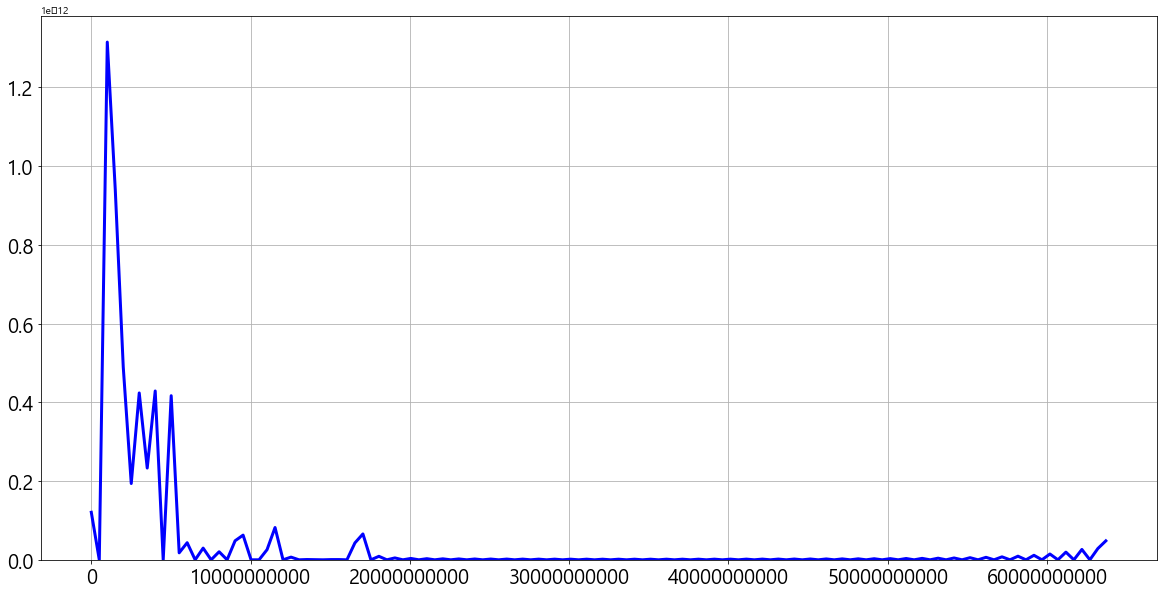

In [14]:
fig, ax =plt.subplots(figsize=(20,10))
plt.ticklabel_format(style='plain', axis='x')
#plt.title("전체 데이터 종속변수 분포도", fontsize=25, fontweight='bold')
sns.distplot(train_df['KR_TRADE_HSCD_COUNTRYCD'], hist=False, color='blue', kde_kws=dict(linewidth=3))
plt.xlabel(None)
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20)
plt.grid()
#ax.set_xticks(x_tick)
plt.show()

#### 3-2 국가별 대한국 수입액 평균

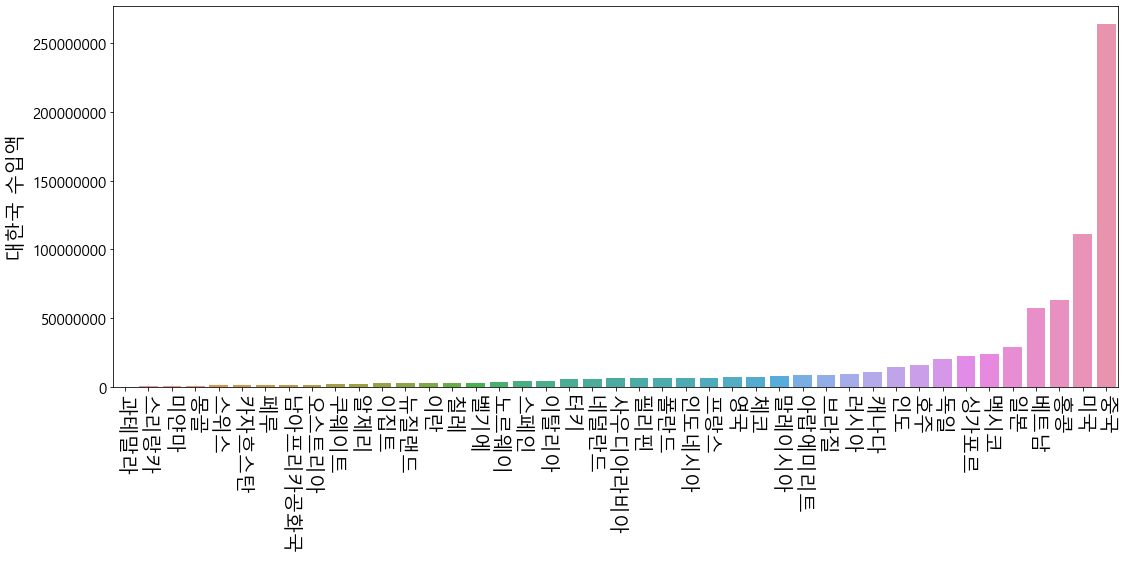

In [15]:
country_grp_mean = country_grp_mean.sort_values('KR_TRADE_HSCD_COUNTRYCD')
plt.figure(figsize=(18,7))
#plt.title("국가별 대한국 수입액 평균", fontsize=25, fontweight='bold')
sns.barplot(country_grp_mean.index,country_grp_mean['KR_TRADE_HSCD_COUNTRYCD'])
plt.xlabel(None)
plt.ylabel("대한국 수입액", fontsize=20)
plt.xticks(rotation = -90, fontsize=20)
plt.yticks(fontsize=15)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [16]:
# 종속변수 기초통계량
pd.DataFrame(train_df.describe()['KR_TRADE_HSCD_COUNTRYCD'])

,KR_TRADE_HSCD_COUNTRYCD
count,21189.000
mean,17939631.961
std,481003321.427
min,0.000
25%,49170.000
50%,349649.000
75%,2307592.000
max,63695330669.000


#### 3-3 국가별/품목별 수출액 변수 분포도(군집별 데이터)

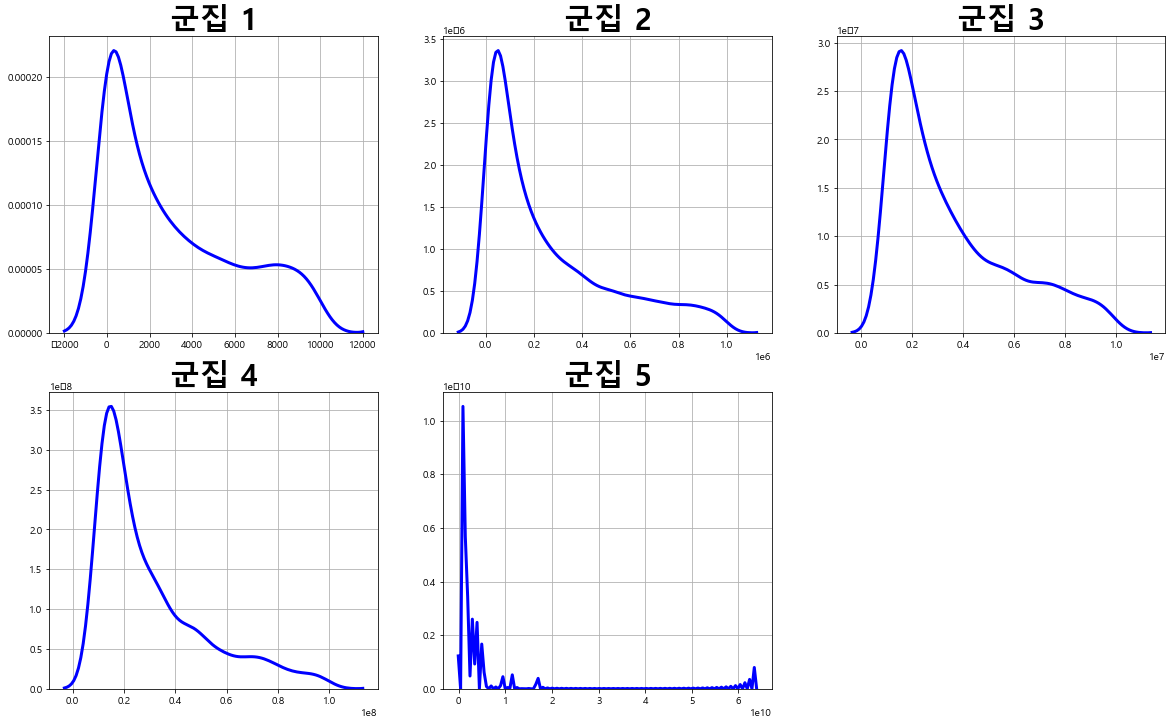

In [17]:
fig = plt.figure(figsize=(20,12))
for i, df in zip(range(1, 6), [hs6_train_df_0, hs6_train_df_1, hs6_train_df_2, hs6_train_df_3, hs6_train_df_4]):
    ax1 = fig.add_subplot(2, 3, i)
    #ax1.yticklabel_format(style='sci', axis='y')
    ax1 = plt.title(f"군집 {i}", fontsize=30, fontweight='bold')
    ax1 = sns.distplot(df['KR_TRADE_HSCD_COUNTRYCD'], hist=False, color='blue', kde_kws=dict(linewidth=3))
    ax1 = plt.ticklabel_format(axis="y", style="plain")
    ax1 = plt.grid()
    ax1 = plt.xlabel(None)
    ax1 = plt.ticklabel_format(style='sci', axis='y')
plt.show()

In [18]:
# 분리된 군집 별 기초통계량
count_cluster = pd.DataFrame(hs6_train_df_0.describe()['KR_TRADE_HSCD_COUNTRYCD'])
count_cluster.columns = ["군집_1"]
count_cluster['군집_2'] = hs6_train_df_1.describe()['KR_TRADE_HSCD_COUNTRYCD'].values
count_cluster['군집_3'] = hs6_train_df_2.describe()['KR_TRADE_HSCD_COUNTRYCD'].values
count_cluster['군집_4'] = hs6_train_df_3.describe()['KR_TRADE_HSCD_COUNTRYCD'].values
count_cluster['군집_5'] = hs6_train_df_4.describe()['KR_TRADE_HSCD_COUNTRYCD'].values
count_cluster

,군집_1,군집_2,군집_3,군집_4,군집_5
count,2626.000,11093.000,5069.000,1995.000,406.000
mean,3025.714,257048.620,3502275.209,30438794.695,735923761.862
std,3022.494,259598.559,2339254.326,21259375.100,3401611749.175
min,0.000,10017.000,1000844.000,10018681.000,100031034.000
25%,300.000,51220.000,1608952.000,14279626.000,139109760.250
50%,1974.000,153051.000,2674652.000,22060403.000,214747297.500
75%,5183.500,390529.000,4874216.000,40001879.000,440903908.250
max,9996.000,999996.000,9998596.000,99796985.000,63695330669.000


#### 3-4 군집별 국가 등장 횟수

In [19]:
count_country_cluster = pd.DataFrame(hs6_train_df_0['국가명'].value_counts()).reset_index().iloc[:10]
count_country_cluster.columns = ['군집_1', '군집_1_count']

count_country_cluster['군집_2'] = hs6_train_df_1['국가명'].value_counts().index[:10]
count_country_cluster['군집_2_count'] = hs6_train_df_1['국가명'].value_counts().values[:10]

count_country_cluster['군집_3'] = hs6_train_df_2['국가명'].value_counts().index[:10]
count_country_cluster['군집_3_count'] = hs6_train_df_2['국가명'].value_counts().values[:10]

count_country_cluster['군집_4'] = hs6_train_df_3['국가명'].value_counts().index[:10]
count_country_cluster['군집_4_count'] = hs6_train_df_3['국가명'].value_counts().values[:10]

count_country_cluster['군집_5'] = hs6_train_df_4['국가명'].value_counts().index[:10]
count_country_cluster['군집_5_count'] = hs6_train_df_4['국가명'].value_counts().values[:10]

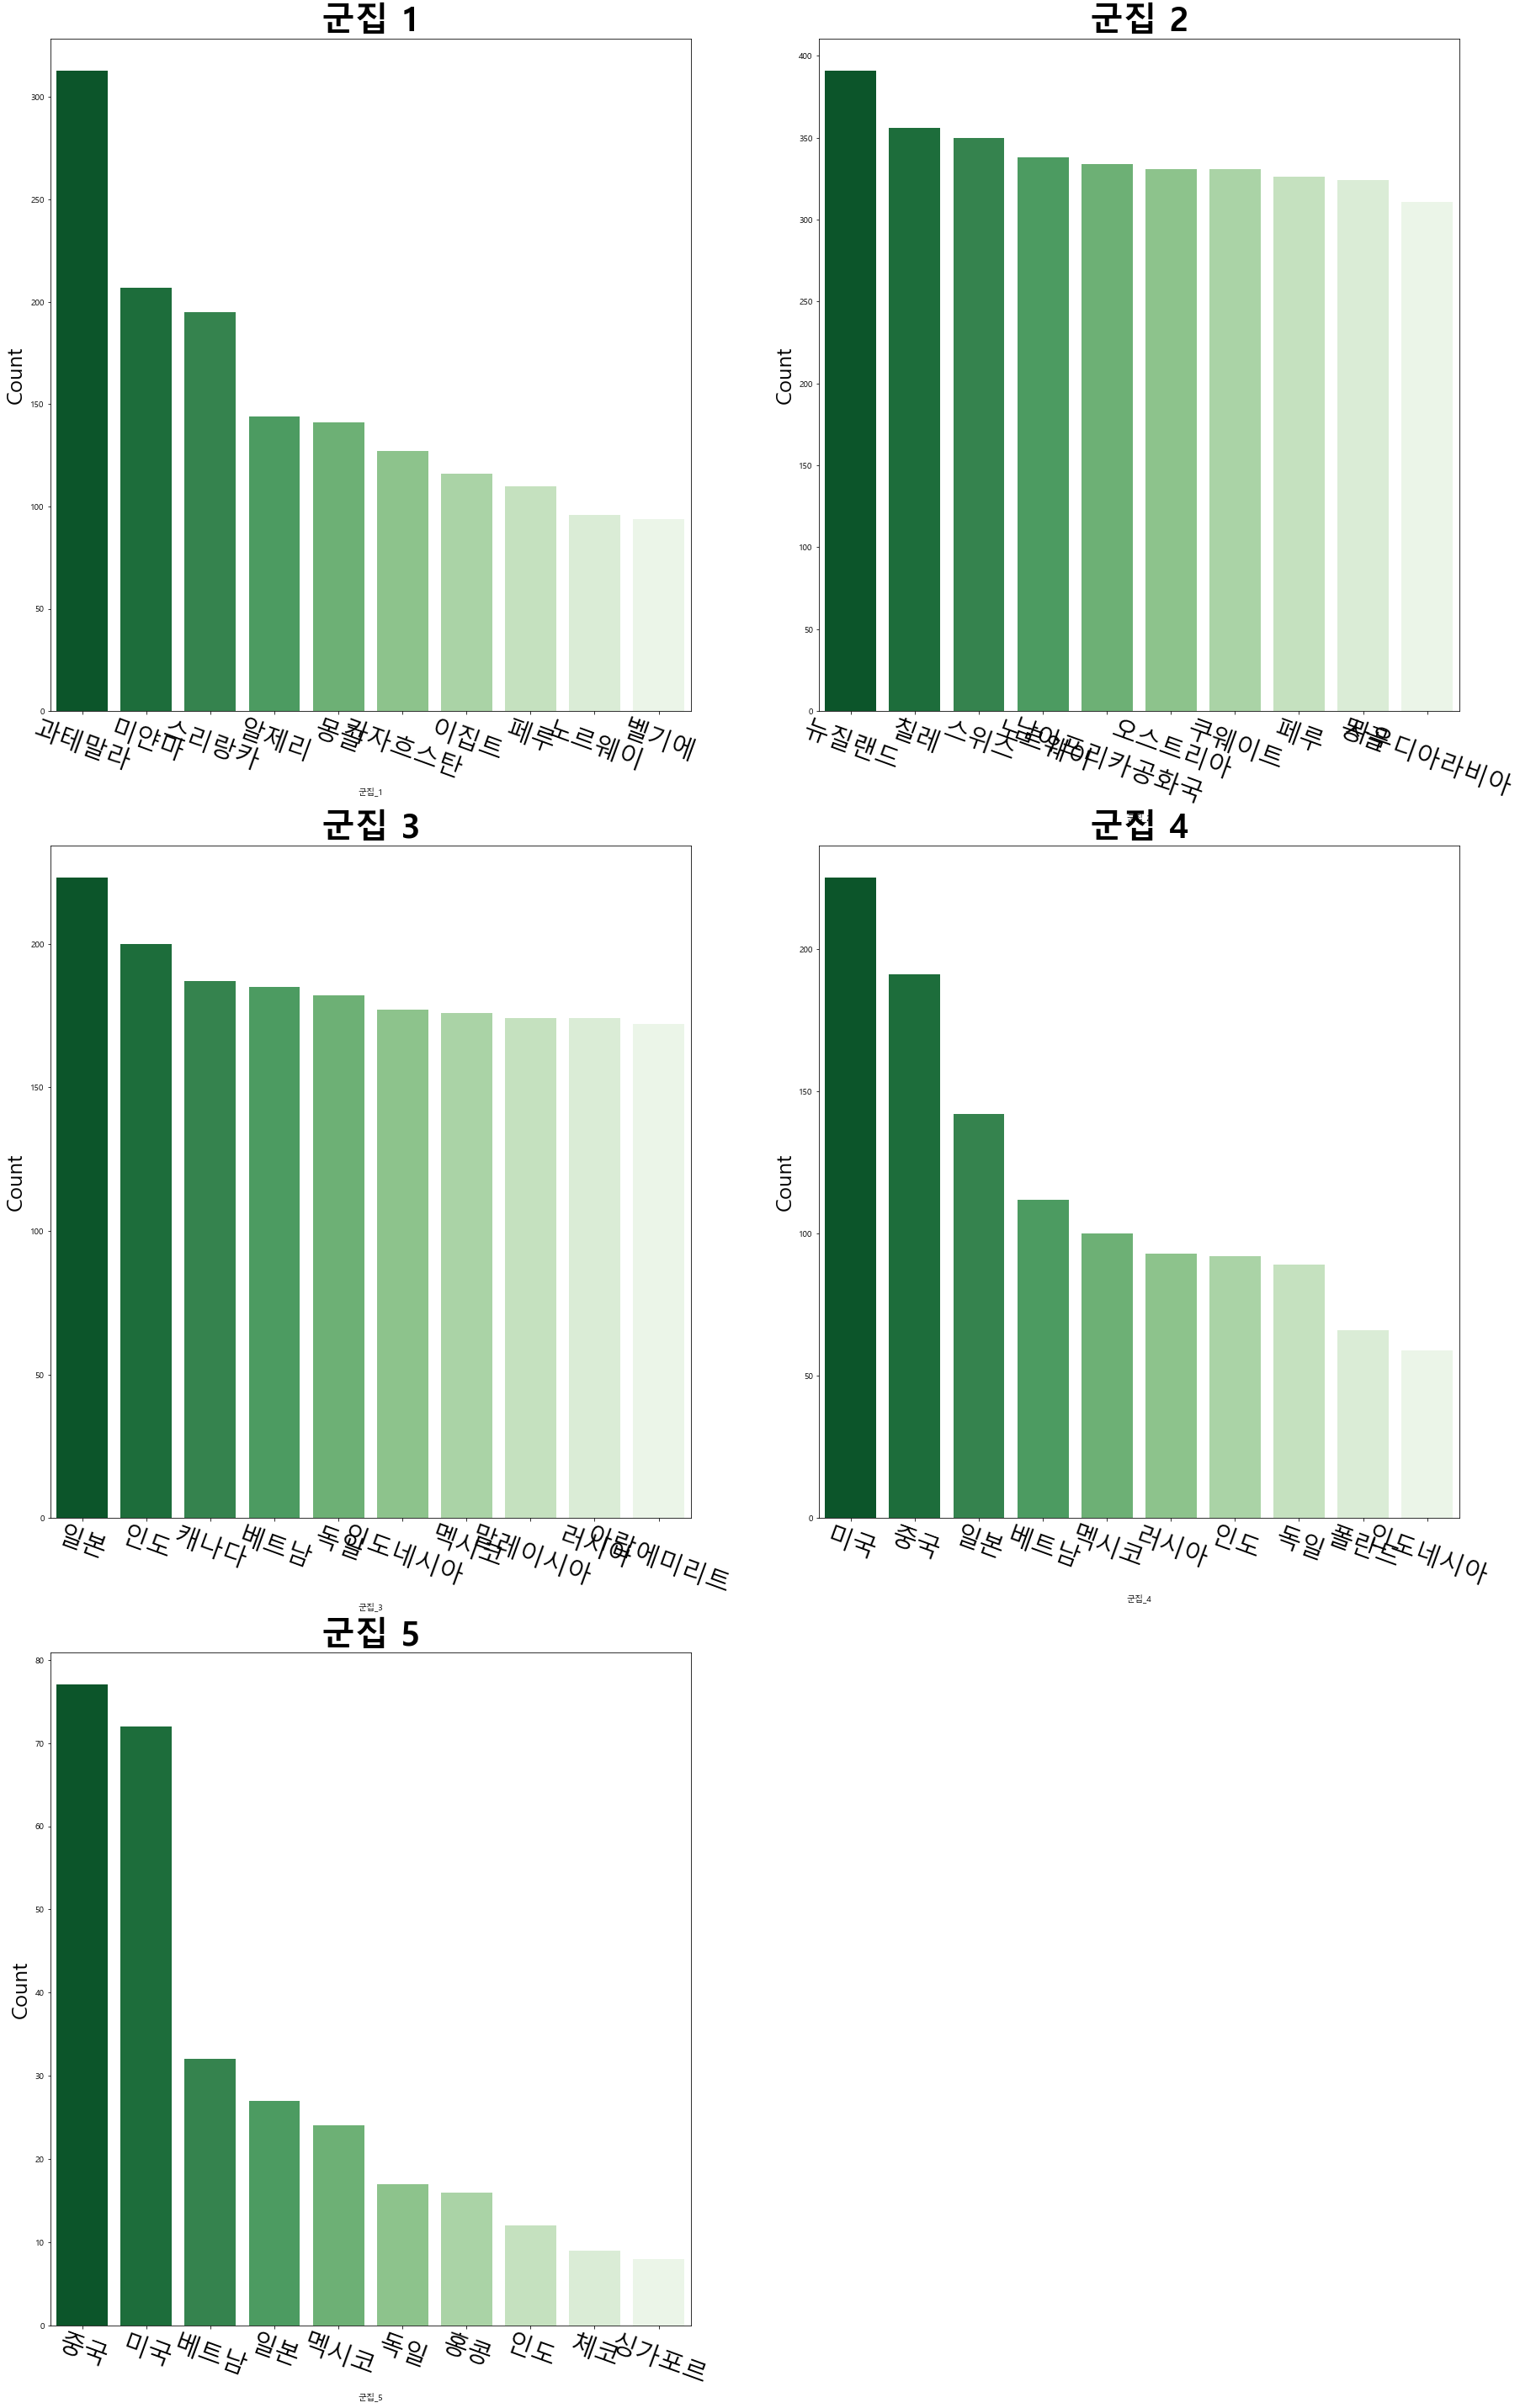

In [20]:
fig = plt.figure(figsize=(30,50))
for num in range(1, 6):
    ax1 = fig.add_subplot(3, 2, num)
    ax1 = plt.title(f"군집 {num}", fontsize=40, fontweight='bold')
    ax1 = sns.barplot(count_country_cluster[f'군집_{num}'],count_country_cluster[f'군집_{num}_count'].values, palette='Greens_r')
    #ax1 = plt.xlabel("국가명", fontsize=10)
    ax1 = plt.ylabel("Count", fontsize=25)
    ax1 = plt.xticks(rotation = -20, fontsize=30)
plt.show()

#### 3-5 군집별 국가별 대한국 수입액 합계

In [21]:
country_cluster_0_sum = hs6_train_df_0.groupby(['국가명']).sum().sort_values('KR_TRADE_HSCD_COUNTRYCD')
country_cluster_1_sum = hs6_train_df_1.groupby(['국가명']).sum().sort_values('KR_TRADE_HSCD_COUNTRYCD')
country_cluster_2_sum = hs6_train_df_2.groupby(['국가명']).sum().sort_values('KR_TRADE_HSCD_COUNTRYCD')
country_cluster_3_sum = hs6_train_df_3.groupby(['국가명']).sum().sort_values('KR_TRADE_HSCD_COUNTRYCD')
country_cluster_4_sum = hs6_train_df_4.groupby(['국가명']).sum().sort_values('KR_TRADE_HSCD_COUNTRYCD')

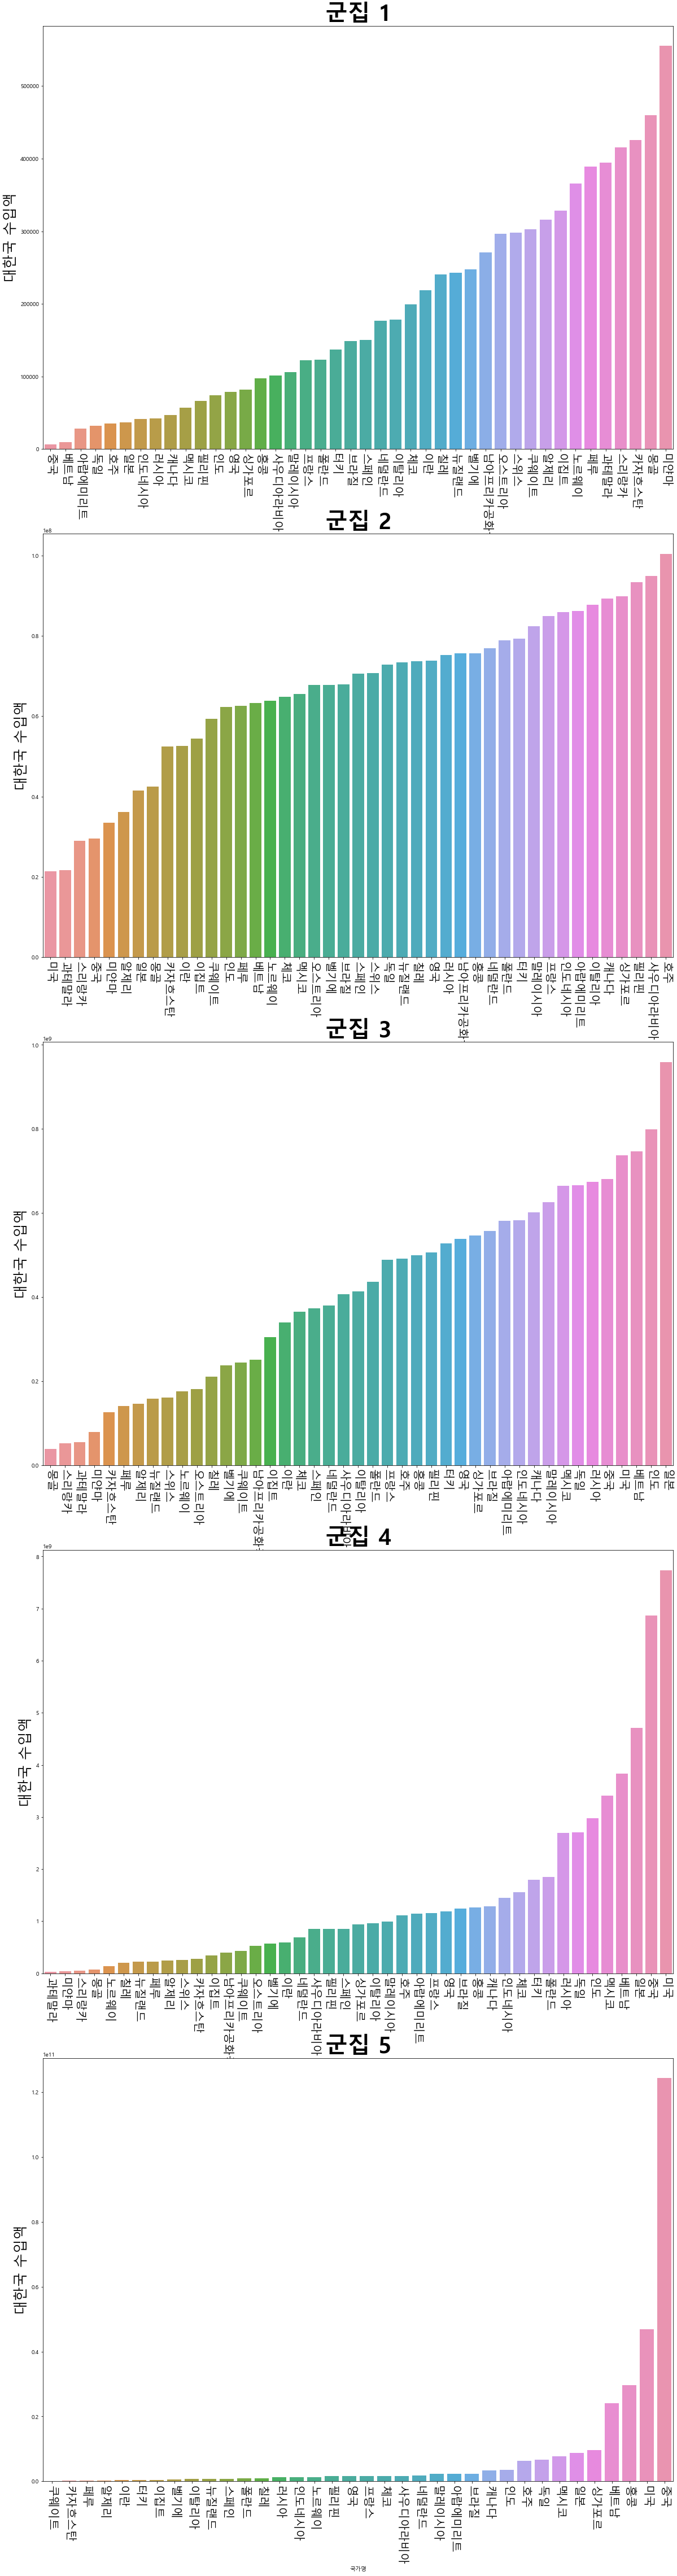

In [22]:
fig = plt.figure(figsize=(20,80))
for i, df in zip(range(1, 6), [country_cluster_0_sum, country_cluster_1_sum, country_cluster_2_sum, 
                               country_cluster_3_sum, country_cluster_4_sum]):
    ax1 = fig.add_subplot(5, 1, i)
    ax1 = plt.title(f"군집 {i}", fontsize=40, fontweight='bold')
    ax1 = sns.barplot(df.index, df['KR_TRADE_HSCD_COUNTRYCD'].values)
    ax1 = plt.ylabel("대한국 수입액", fontsize=25)
    ax1 = plt.xticks(rotation = -90, fontsize=20)

#### 3-6 군집별 품목 등장 횟수

In [23]:
count_hs_cluster = pd.DataFrame(hs6_train_df_0['HSCD'].value_counts()).reset_index().iloc[:10]
count_hs_cluster.columns = ['군집_1', '군집_1_count']

count_hs_cluster['군집_2'] = hs6_train_df_1['HSCD'].value_counts().index[:10]
count_hs_cluster['군집_2_count'] = hs6_train_df_1['HSCD'].value_counts().values[:10]

count_hs_cluster['군집_3'] = hs6_train_df_2['HSCD'].value_counts().index[:10]
count_hs_cluster['군집_3_count'] = hs6_train_df_2['HSCD'].value_counts().values[:10]

count_hs_cluster['군집_4'] = hs6_train_df_3['HSCD'].value_counts().index[:10]
count_hs_cluster['군집_4_count'] = hs6_train_df_3['HSCD'].value_counts().values[:10]

count_hs_cluster['군집_5'] = hs6_train_df_4['HSCD'].value_counts().index[:10]
count_hs_cluster['군집_5_count'] = hs6_train_df_4['HSCD'].value_counts().values[:10]

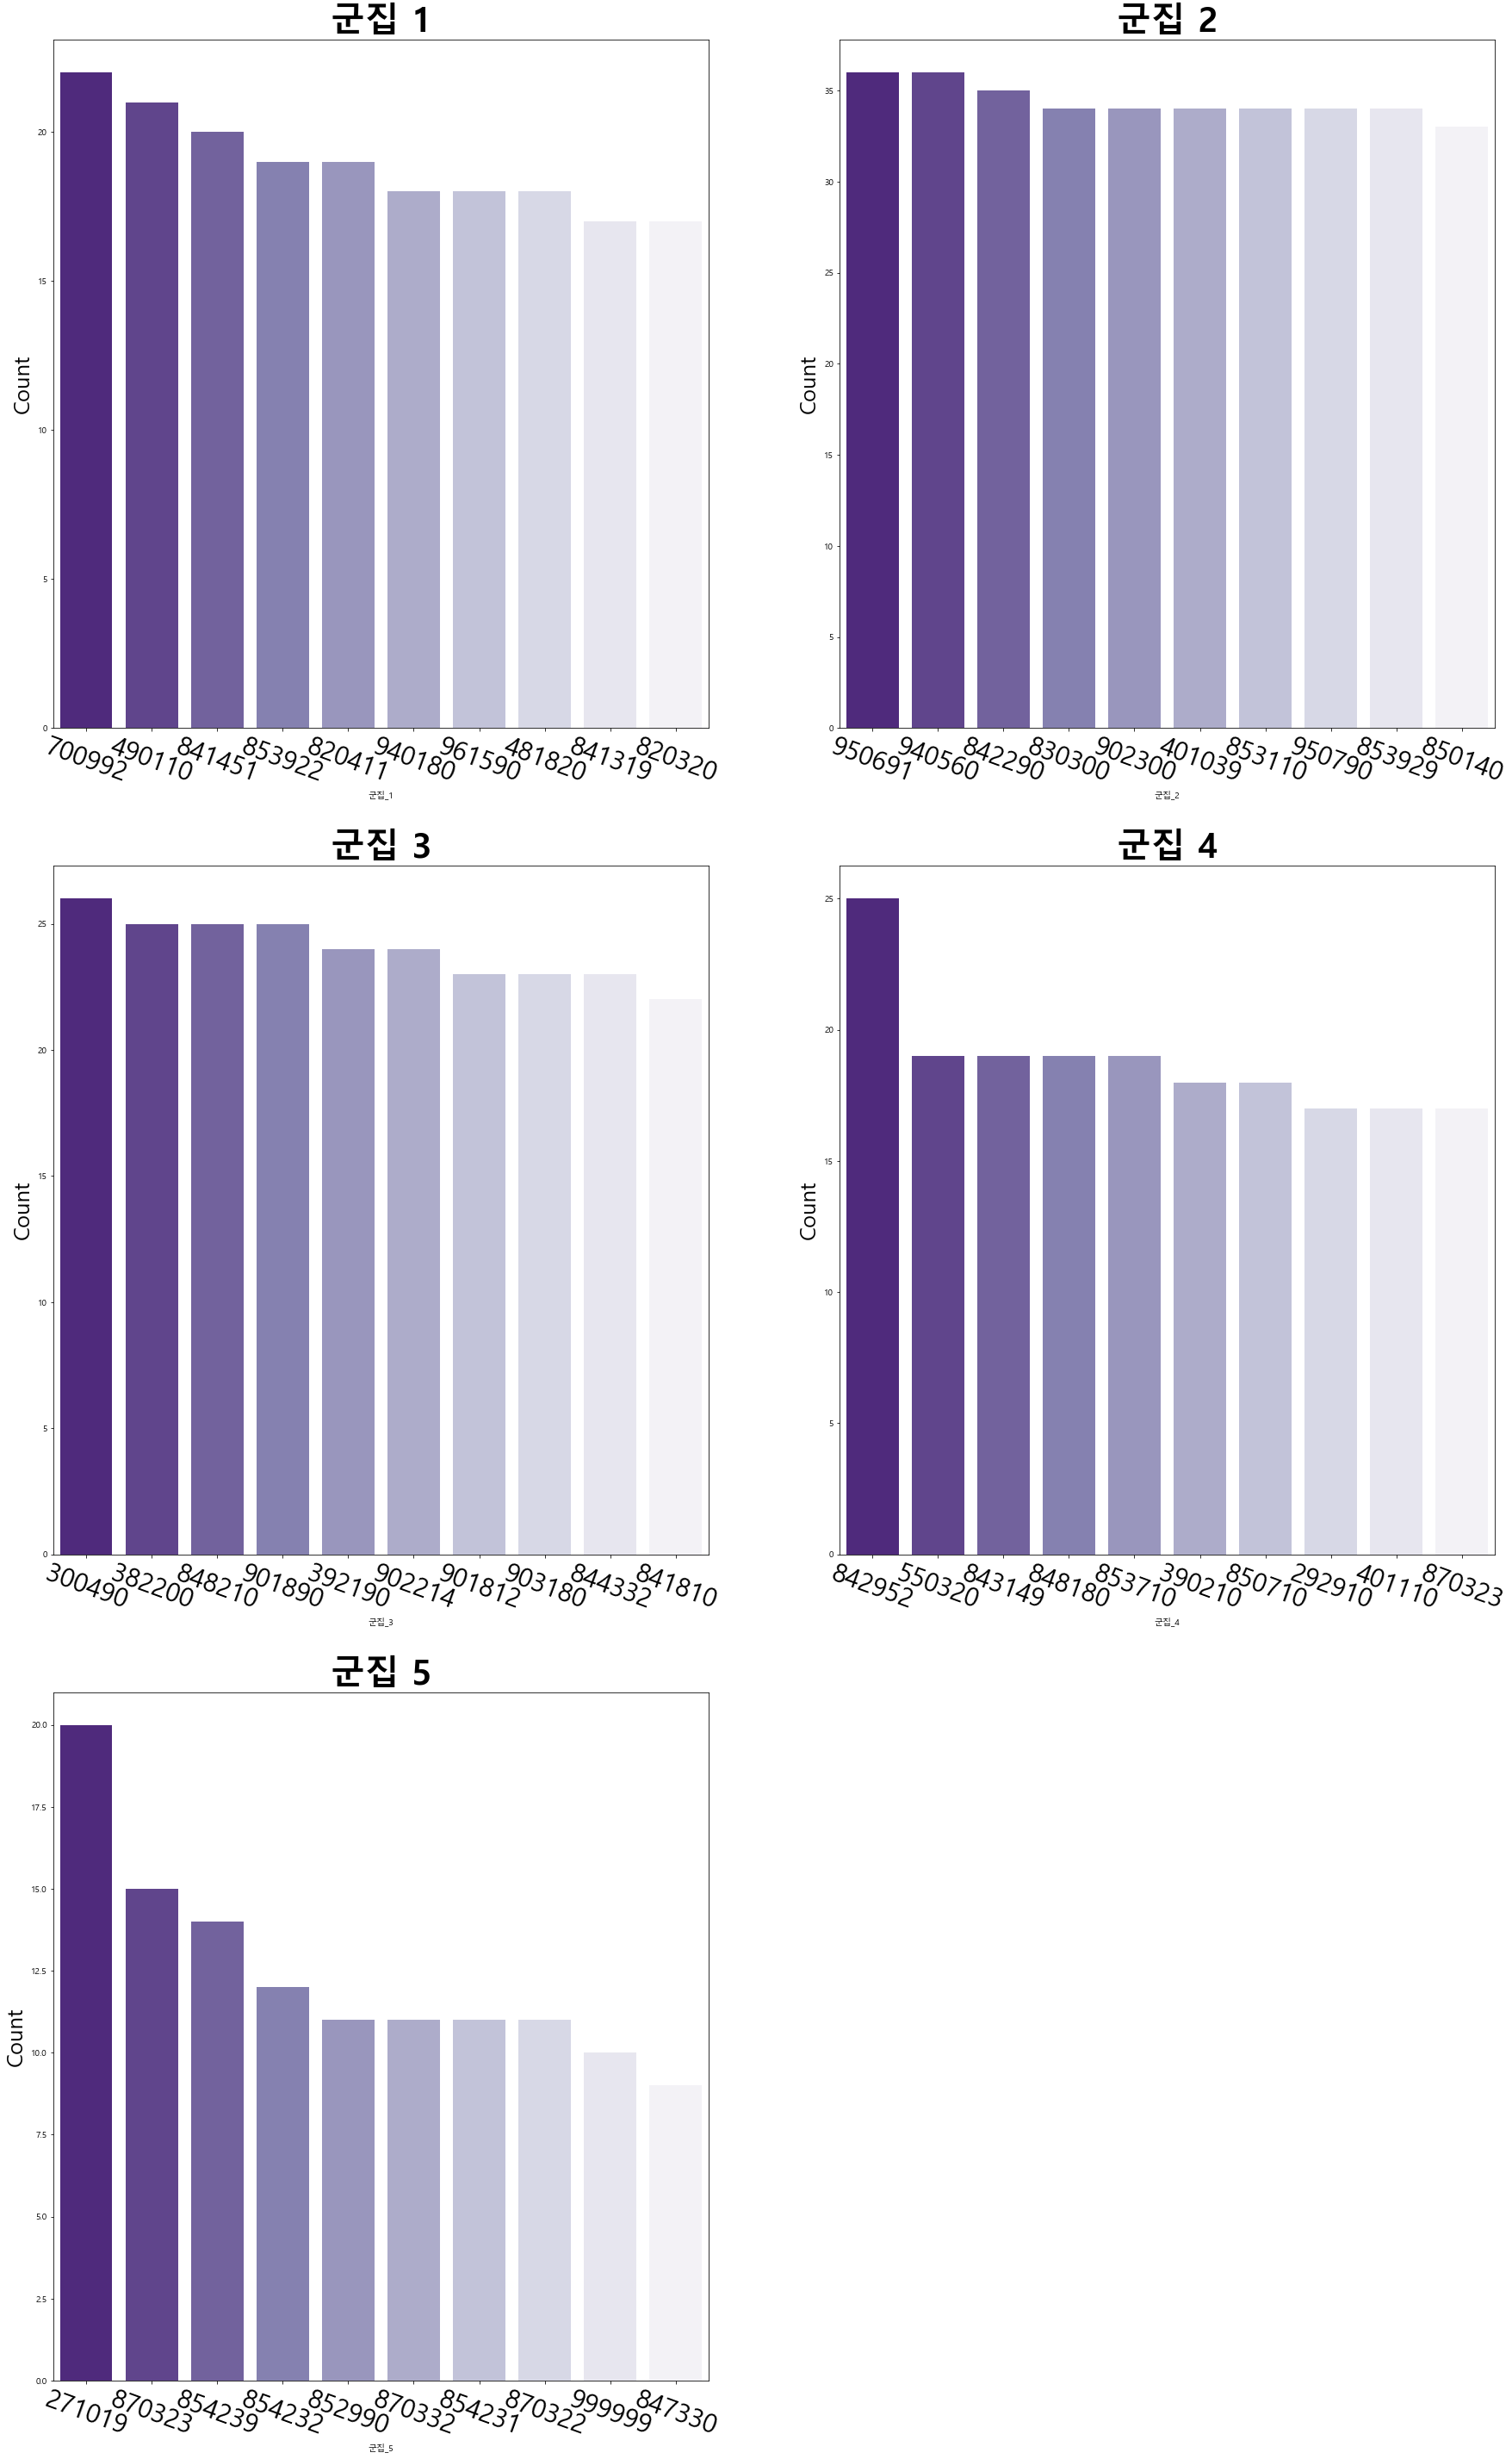

In [24]:
fig = plt.figure(figsize=(30,50))
for num in range(1, 6):
    ax1 = fig.add_subplot(3, 2, num)
    ax1 = plt.title(f"군집 {num}", fontsize=40, fontweight='bold')
    ax1 = sns.barplot(count_hs_cluster[f'군집_{num}'],count_hs_cluster[f'군집_{num}_count'].values,  order=count_hs_cluster[f'군집_{num}'],
                      palette='Purples_r')
    #ax1 = plt.xlabel("국가명", fontsize=10)
    ax1 = plt.ylabel("Count", fontsize=25)
    ax1 = plt.xticks(rotation = -20, fontsize=30)
plt.show()

#### 3-7 군집, 품목별 수입액 합계(상위 10개)

In [25]:
hs_cluster_0_sum = hs6_train_df_0.groupby(['HSCD']).sum().sort_values('KR_TRADE_HSCD_COUNTRYCD', ascending=False).iloc[:10]
hs_cluster_1_sum = hs6_train_df_1.groupby(['HSCD']).sum().sort_values('KR_TRADE_HSCD_COUNTRYCD', ascending=False).iloc[:10]
hs_cluster_2_sum = hs6_train_df_2.groupby(['HSCD']).sum().sort_values('KR_TRADE_HSCD_COUNTRYCD', ascending=False).iloc[:10]
hs_cluster_3_sum = hs6_train_df_3.groupby(['HSCD']).sum().sort_values('KR_TRADE_HSCD_COUNTRYCD', ascending=False).iloc[:10]
hs_cluster_4_sum = hs6_train_df_4.groupby(['HSCD']).sum().sort_values('KR_TRADE_HSCD_COUNTRYCD', ascending=False).iloc[:10]

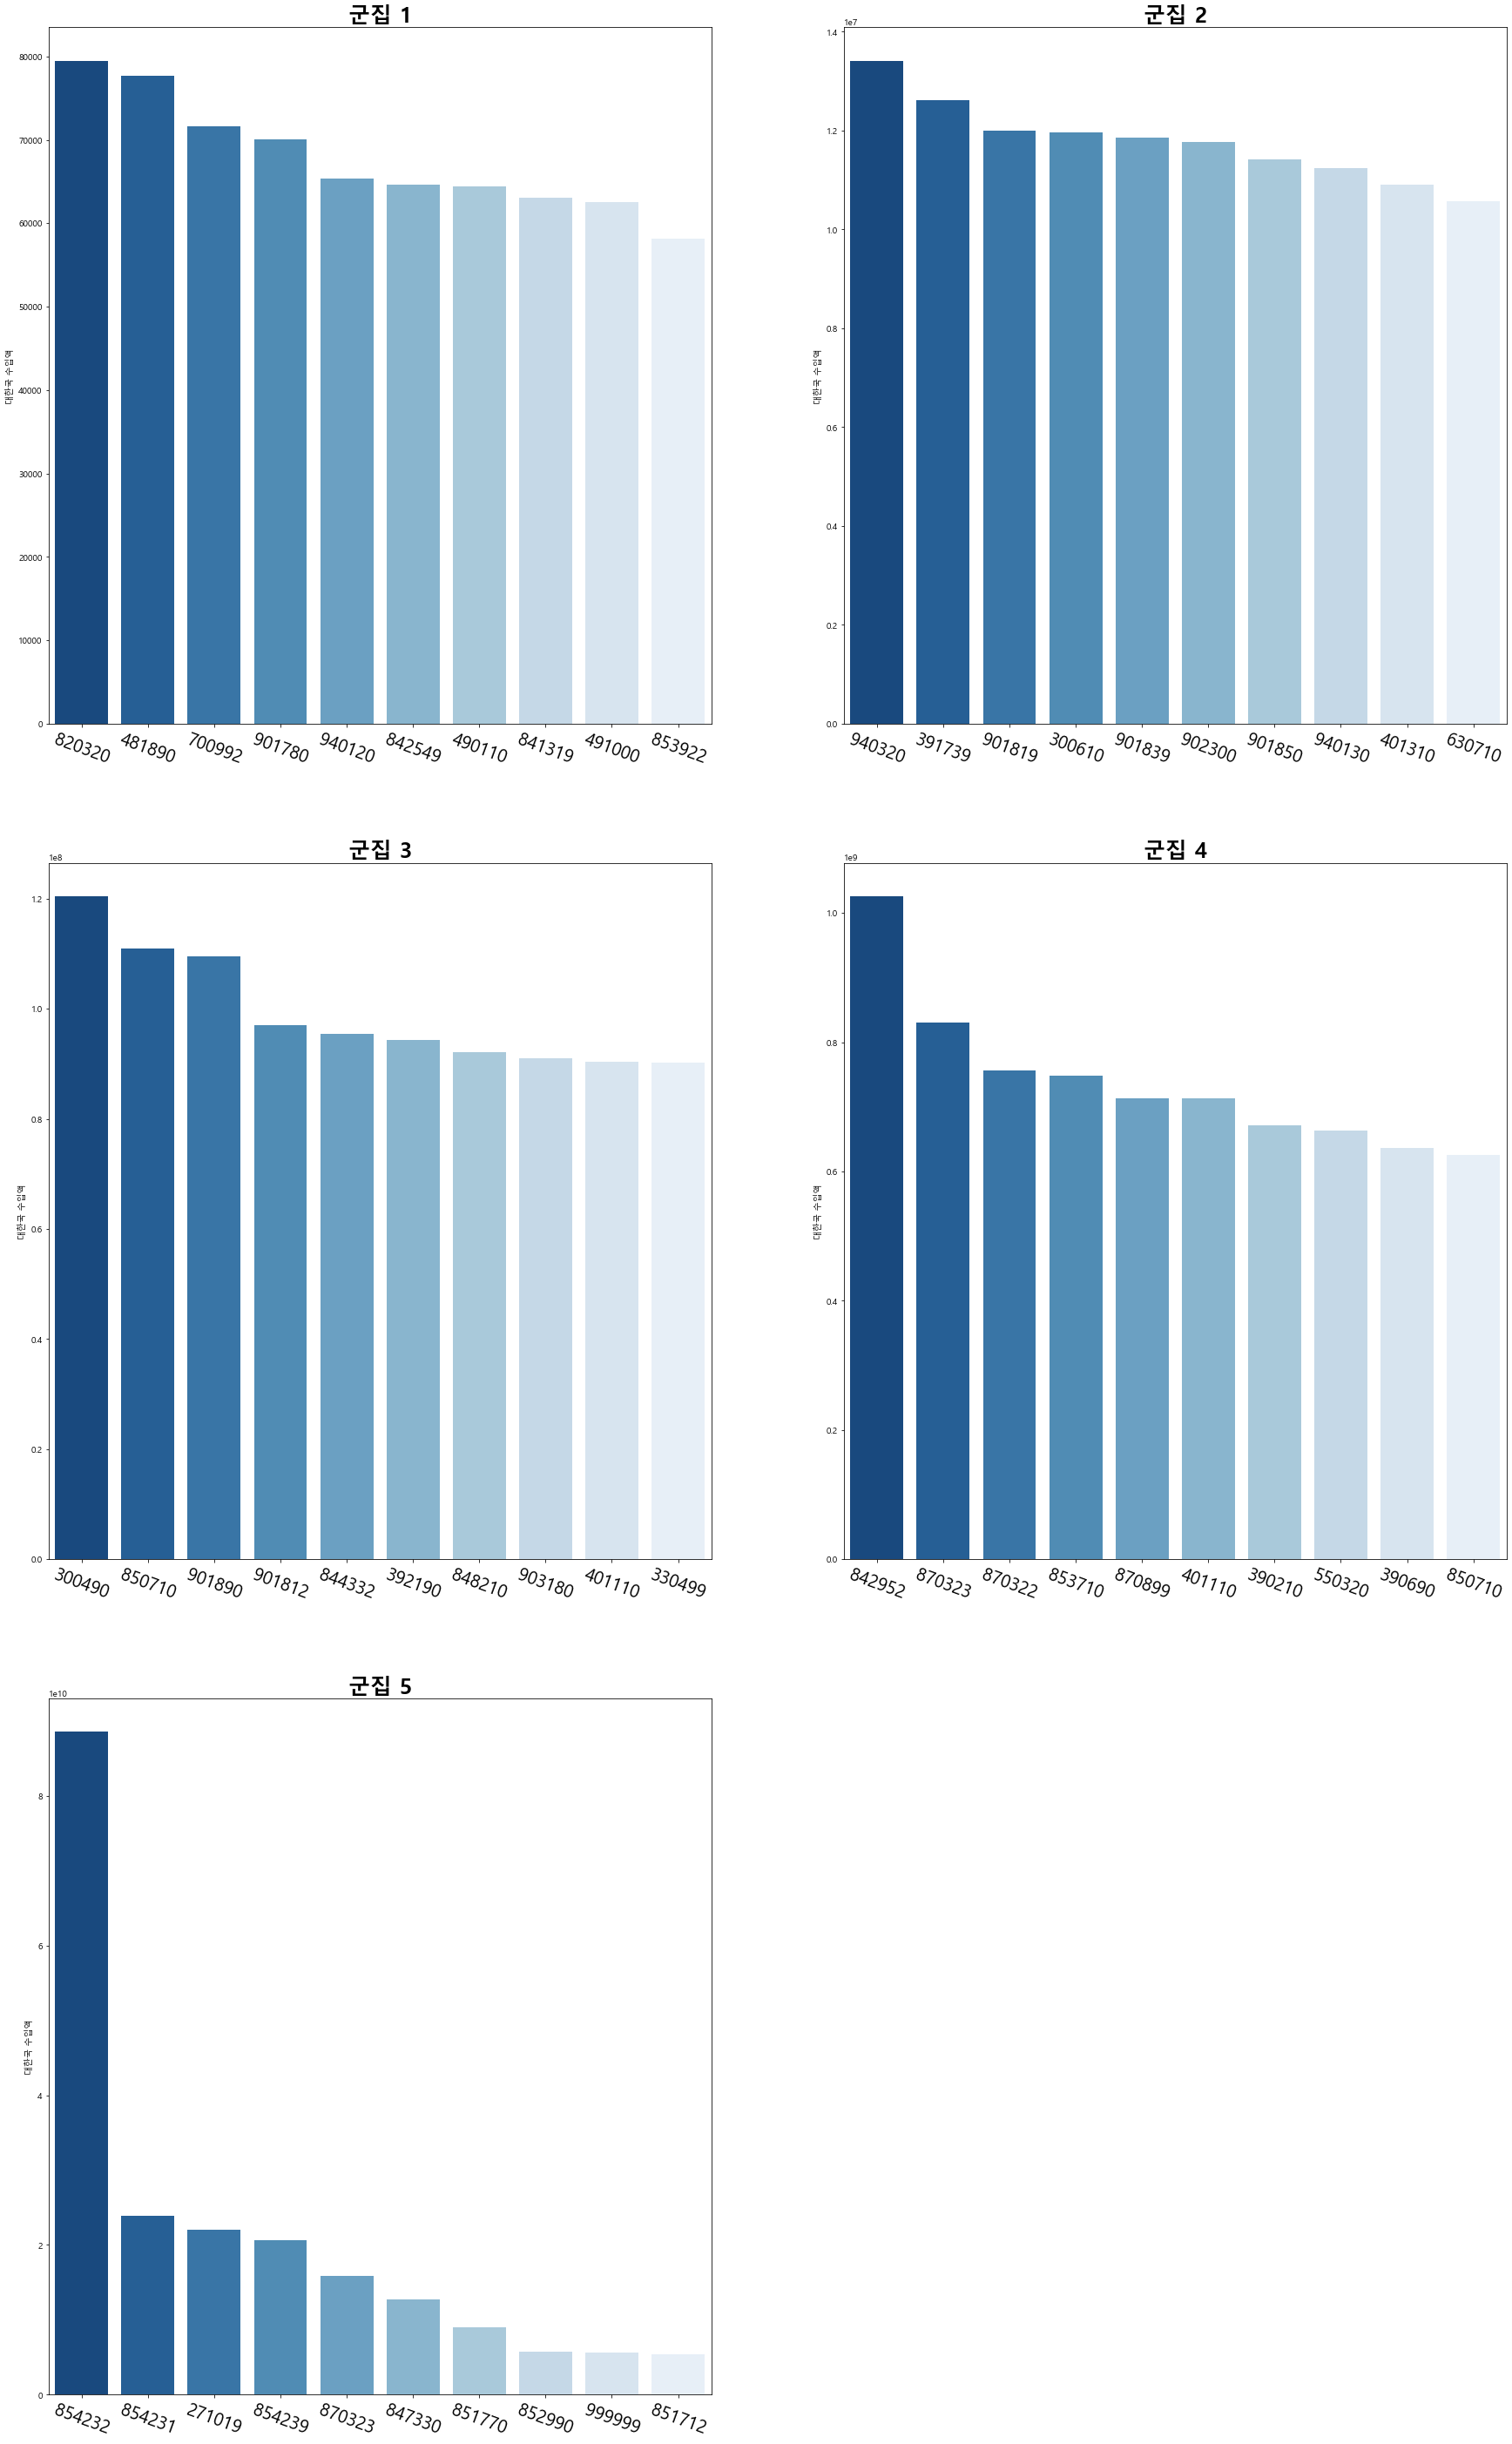

In [26]:
fig = plt.figure(figsize=(30, 50))
for i, df in zip(range(1, 6), [hs_cluster_0_sum, hs_cluster_1_sum, hs_cluster_2_sum, 
                               hs_cluster_3_sum, hs_cluster_4_sum]):
    ax = fig.add_subplot(3, 2, i)
    ax = plt.title(f"군집 {i}", fontsize=25, fontweight='bold')
    ax = sns.barplot(df.index, df['KR_TRADE_HSCD_COUNTRYCD'], order=df.index
                     , palette='Blues_r')
    ax = plt.xlabel(None)
    ax = plt.ylabel("대한국 수입액", fontsize=10)
    ax = plt.xticks(rotation = -20, fontsize=20)
plt.show()

## 3. 변수 선정 by t-test + Stepwise &  Modeling
### 함수

In [27]:
# 더미 변수 생성
def make_dummy_df(df):
    #더미변수용 데이터 따로 저장(국가명, TOP_HSCD코드)
    dummy_var = ['COUNTRYNM','TOP_HSCD']
    df_for_dummy = df[dummy_var]
    
    # 더미변수 만들기
    HSCD = pd.get_dummies(df_for_dummy['TOP_HSCD'], drop_first = True, prefix = 'TOP_HSCD')
    COUNTRYNM = pd.get_dummies(df_for_dummy['COUNTRYNM'], drop_first = True, prefix = 'COUNTRYNM')

    #따로 만들고 종속변수랑 T검정 위해 종속변수도 함께
    df_for_dummy = pd.concat([df['KR_TRADE_HSCD_COUNTRYCD'], HSCD, COUNTRYNM], axis = 1)
    
    return df_for_dummy

In [28]:
# 더미 변수 t-test
def dummy_t_test(df_for_dummy, original_df):
    # 더미변수 t-test
    results_ttest = []

    for i in range(1,len(df_for_dummy.columns)):
        df_for_ttest = df_for_dummy.iloc[:,[0,i]]
        var_name = df_for_ttest.columns[1]
        first_group = df_for_ttest[df_for_ttest.iloc[:,1] == 0]['KR_TRADE_HSCD_COUNTRYCD']
        second_group = df_for_ttest[df_for_ttest.iloc[:,1] == 1]['KR_TRADE_HSCD_COUNTRYCD']
        equal_var_test = levene(first_group, second_group)
        if equal_var_test[1] > 0.05:
            ttest_ = ttest_ind(first_group, second_group, equal_var = True)
            if ttest_[1] > 0.05:
                results_ttest.append([var_name, ttest_[1], '1'])
            else:
                results_ttest.append([var_name, ttest_[1], ''])
        else:
            ttest_ = ttest_ind(first_group, second_group, equal_var = False)
            if ttest_[1] > 0.05:
                results_ttest.append([var_name, ttest_[1], '1'])  
            else:
                results_ttest.append([var_name, ttest_[1], '']) 
    results_ttest = pd.DataFrame(results_ttest)
    results_ttest.columns = ['var_name','ttest_p_value','drop']
    result_ttest = results_ttest[results_ttest['drop'] != '1']
    
    return result_ttest

In [29]:
def fta_t_test(df):
    #FTA는 따로 T검정 실시
    ## 집단 나누기
    first_group = df[df['FTA'] == 0]['KR_TRADE_HSCD_COUNTRYCD']
    second_group = df[df['FTA'] == 1]['KR_TRADE_HSCD_COUNTRYCD']

    ## 등분산 검정 실시(p값이 0.05 이상이면 등분산, 아니면 이분산)
    ## 등분산 여부로 t검정에서 equal_var 옵션을 결정
    equal_var_test = levene(first_group, second_group)

    if equal_var_test[1] > 0.05:
        ttest_ = ttest_ind(first_group, second_group, equal_var = True)
        if ttest_[1] > 0.05:
            print(f"FTA t-test 결과: {[ttest_[1], 'drop']}")
        else:
            print(f"FTA t-test 결과: {[ttest_[1], '']}")
    else:
        ttest_ = ttest_ind(first_group, second_group, equal_var = False)
        if ttest_[1] > 0.05:
            print(f"FTA t-test 결과: {[ttest_[1], 'drop']}")  
        else:
            print(f"FTA t-test 결과: {[ttest_[1], '']}")  

In [30]:
def t_test(df):
    # 더미변수용 데이터 따로 저장(국가명, TOP_HSCD코드)
    dummy_df = make_dummy_df(df)
    
    # HS, 국가 관련 변수 원 데이터에서 제거
    df = df.drop(columns = ['COUNTRYNM','TOP_HSCD','HSCD','COUNTRYCD','COUNTRYCODE', '국가명'])

    #더미 변수와 종속변수간의 T검정
    result_ttest = dummy_t_test(dummy_df, df)

    # t-test에서 유의한 더미 변수 반환
    use_dummy_varname = list(result_ttest[result_ttest['drop'] != '1']['var_name'])
    use_dummy_varname

    # 유의한 더미 변수 추가한 데이터프레임 생성
    df_after_ttest = pd.concat([df, dummy_df[use_dummy_varname]], axis = 1)
    
    # 데이터프레임 반환
    return df_after_ttest

In [31]:
def separate(df):
    # X,y, 분리
    X = df.drop(columns = 'KR_TRADE_HSCD_COUNTRYCD')
    y = df.KR_TRADE_HSCD_COUNTRYCD
    
    return X, y

In [32]:
def log_scale_xy(X, y):
    #로그변환(종속변수)
    log_y = np.log1p(y)

    #정규화(독립변수)
    scaler = MinMaxScaler()
    colname = X.columns

    scaled_X = pd.DataFrame(scaler.fit_transform(X), columns = colname)
    scaled_X
    
    return scaled_X, log_y

#### stepwise_forward, backward를 이용한 변수선정

In [33]:
#학습모델 결정
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(scaled_X[variables], log_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(log_y, [log_y.mean()] * len(log_y), model, df=1)
    return AIC_score(log_y, model.predict(scaled_X[variables]), model)

In [34]:
def stepwise(method_step):
    best_variables = []
    if method_step == "forward":
        best_model_forward, best_variables = forward_selection(scaled_X.columns, train_model, score_model, verbose=True)
    elif method_step == "backward":
        best_model_backward, best_variables = backward_elimination(scaled_X.columns, train_model, score_model, verbose=True)
    
    elif method_step == "both":
        best_model_both, best_variables = stepwise_selection(scaled_X.columns, train_model, score_model, verbose=True)
    
    print("Best Variable: ", best_variables)
    return best_variables

#### convert_dataframe

In [35]:
# 종속변수 로그 변환, 입력변수 정규화(Minmax)
## 학습데이터 - 2018
def convert_dataframe(traindata, testdata):
    log_y_train = np.log1p(traindata['KR_TRADE_HSCD_COUNTRYCD'])
    
    X_train = traindata.drop(columns = 'KR_TRADE_HSCD_COUNTRYCD')
    X_test = testdata
    
    col_name = X_train.columns
    
    scaler = MinMaxScaler()
    scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = col_name)
    
    scaled_X_test = pd.DataFrame(scaler.transform(X_test), columns = col_name)
    
    return scaled_X_train, log_y_train, scaled_X_test

## 모델 알고리즘

In [36]:
def algorithm_pipeline(X_train_data, y_train_data, 
                       model, param_grid, cv=5, scoring_fit='neg_root_mean_squared_error'):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    return fitted_model

In [37]:
# light gradient boosting machine
def lgbm():
    model = lgb.LGBMRegressor()

    #하이퍼파라미터 설정
    param_grid = {
        'boosting_type': ['gbdt'], # 보통 수상한 팀 보면 전부 이것 씀
        'objective': ['regression','regression_l1'],
        'n_estimators': [1000,1500, 2000],
        'learning_rate': [0.1, 0.01, 0.05, 0.001],
        'max_depth': [15,20,30],
        'num_leaves': [30, 50],
        'min_split_gain': [0.3, 0.4],
        'subsample': [0.7, 0.9],
        'bagging_fraction' : [0.9],

    }
    return model, param_grid

In [38]:
# 지수 평균
def moving_average(data):
    pred_test = []
    for i in data.index:
        if (data['KR_TRADE_HSCD_COUNTRYCD_3'][i] == 0 and data['KR_TRADE_HSCD_COUNTRYCD_2'][i] != 0 and data['KR_TRADE_HSCD_COUNTRYCD_1'][i] != 0):
            pred = data['KR_TRADE_HSCD_COUNTRYCD_1'][i]*2/3 + data['KR_TRADE_HSCD_COUNTRYCD_2'][i]*1/3
        elif (data['KR_TRADE_HSCD_COUNTRYCD_3'][i] == 0 and data['KR_TRADE_HSCD_COUNTRYCD_2'][i] == 0 and data['KR_TRADE_HSCD_COUNTRYCD_1'][i] != 0):
            pred = data['KR_TRADE_HSCD_COUNTRYCD_1'][i]
        elif (data['KR_TRADE_HSCD_COUNTRYCD_3'][i] == 0 and data['KR_TRADE_HSCD_COUNTRYCD_2'][i] == 0 and data['KR_TRADE_HSCD_COUNTRYCD_1'][i] == 0):
            pred = 0
        else: 
            pred = data['KR_TRADE_HSCD_COUNTRYCD_1'][i]*3/6 + data['KR_TRADE_HSCD_COUNTRYCD_2'][i]*2/6 + data['KR_TRADE_HSCD_COUNTRYCD_3'][i]*1/6
        pred_test.append(pred)
    return np.array(pred_test)

#### start function

In [39]:
def start_test(stepwise_method, model, target_train_df, target_test_df, outliers):


    train_dummy_df = make_dummy_df(target_train_df)
    test_dummy_df = make_dummy_df(target_test_df)

    # HS, 국가 관련 변수 원 데이터에서 제거
    target_train_df = target_train_df.drop(columns = ['COUNTRYNM','TOP_HSCD','HSCD','COUNTRYCD', '국가명'])

    #더미 변수와 종속변수간의 T검정
    result_ttest = dummy_t_test(train_dummy_df, target_train_df)

    # t-test에서 유의한 더미 변수 반환
    use_dummy_varname = list(result_ttest[result_ttest['drop'] != '1']['var_name'])

    # 유의한 더미 변수 추가한 데이터프레임 생성
    train_after_ttest = pd.concat([target_train_df, train_dummy_df[use_dummy_varname]], axis = 1)
    test_after_ttest = pd.concat([target_test_df, test_dummy_df[use_dummy_varname]], axis = 1)
        
    global X
    global y
    global scaled_X
    global log_y
    X, y = separate(train_after_ttest)

    scaled_X, log_y = log_scale_xy(X, y)    

    global X_train
    global X_val
    global X_test
    
    global y_train
    global y_val
    
    if outliers == 0:
        #stepwise 변수선정
        best_variables = stepwise(stepwise_method)
        # 선정된 변수 대입
        ## 학습데이터
        train_df = train_after_ttest[best_variables]
        train_df['KR_TRADE_HSCD_COUNTRYCD'] = target_train_df['KR_TRADE_HSCD_COUNTRYCD']

        ## 평가데이터
        test_df = test_after_ttest[best_variables]
        X_train, y_train, X_test = convert_dataframe(train_df, test_df)
        
        
    else:
        X_train = train_after_ttest[['KR_TRADE_HSCD_COUNTRYCD_1','KR_TRADE_HSCD_COUNTRYCD_2','KR_TRADE_HSCD_COUNTRYCD_3']]
        y_train = target_train_df['KR_TRADE_HSCD_COUNTRYCD']
        X_test = test_after_ttest[['KR_TRADE_HSCD_COUNTRYCD_1','KR_TRADE_HSCD_COUNTRYCD_2','KR_TRADE_HSCD_COUNTRYCD_3']]
        
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=51)
    
    if outliers == 1:
        pred_val = moving_average(X_val)
        pred_test = moving_average(X_test)
        return X_val, X_test, y_val, pred_val, pred_test
           
    elif outliers == 0:
        global model_current
        global param_grid
        if model == "lgbm":
            model_current, param_grid = lgbm()
            model = algorithm_pipeline(X_train, y_train, model_current, param_grid, cv=5, scoring_fit='neg_root_mean_squared_error')
            pred_val = model.predict(X_val)
            pred_test = model.predict(X_test)
            return model, X_val, X_test, y_val, pred_val, pred_test

#### score function

In [40]:
def get_score(y_test_0, y_test_1, y_test_2, y_test_3, y_test_4, pred_test_0, pred_test_1, pred_test_2, pred_test_3, pred_test_4):
    y_test_list = [ np.expm1(y_test_0), np.expm1(y_test_1),np.expm1(y_test_2), np.expm1(y_test_3), y_test_4]
    pred_list = [ np.expm1(pred_test_0), np.expm1(pred_test_1), np.expm1(pred_test_2), np.expm1(pred_test_3), pred_test_4]
    i = 0
    for y_test, pred in zip(y_test_list, pred_list):
        MAE = mean_absolute_error(y_test, pred)
        RMSE = np.sqrt(mean_squared_error(y_test, pred))
        print(f"---------{i}분위----------")
        print("MAE:", MAE)
        print("RMSE:", RMSE)

        print("\n")
        i += 1
    # TOTAL
    pred_test_result = np.concatenate(( np.expm1(pred_test_0), np.expm1(pred_test_1), np.expm1(pred_test_2), np.expm1(pred_test_3), pred_test_4), axis=0)
    y_test_result = pd.concat([ np.expm1(y_test_0), np.expm1(y_test_1),np.expm1(y_test_2), np.expm1(y_test_3), y_test_4]).reset_index(drop=True)
    
    MAE = mean_absolute_error(y_test_result, pred_test_result)
    RMSE = np.sqrt(mean_squared_error(y_test_result, pred_test_result))
    print("========Total========")
    print("MAE:", MAE)
    print("RMSE:", RMSE)

## Stepwise 기법, Model 선택 & train, test 정해서 대입

### 최종 분리 기법

#### lgbm

In [41]:
#최종 분리 기법
#4군집은 지수이동평균(3)
#0,1,2,3은 LGBM
# forward, backward, both
stepwise_method = "both"


model = 'lgbm'
model0, X_val_lgbm0, X_test_lgbm0, y_val_lgbm0, pred_val_lgbm0, pred_test_lgbm0 = start_test(stepwise_method, model, hs6_train_df_0, hs6_test_df_0, outliers = 0)
model1, X_val_lgbm1, X_test_lgbm1, y_val_lgbm1, pred_val_lgbm1, pred_test_lgbm1 = start_test(stepwise_method, model, hs6_train_df_1, hs6_test_df_1, outliers = 0)
model2, X_val_lgbm2, X_test_lgbm2, y_val_lgbm2, pred_val_lgbm2, pred_test_lgbm2 = start_test(stepwise_method, model, hs6_train_df_2, hs6_test_df_2, outliers = 0)
model3, X_val_lgbm3, X_test_lgbm3, y_val_lgbm3, pred_val_lgbm3, pred_test_lgbm3 = start_test(stepwise_method, model, hs6_train_df_3, hs6_test_df_3, outliers = 0)
X_val_lgbm4, X_test_lgbm4, y_val_lgbm4, pred_val_lgbm4, pred_test_lgbm4 = start_test(stepwise_method, model, hs6_train_df_4, hs6_test_df_4, outliers = 1)

y_val_lgbm0 = y_val_lgbm0.reset_index(drop=True)
y_val_lgbm1 = y_val_lgbm1.reset_index(drop=True)
y_val_lgbm2 = y_val_lgbm2.reset_index(drop=True)
y_val_lgbm3 = y_val_lgbm3.reset_index(drop=True)
y_val_lgbm4 = y_val_lgbm4.reset_index(drop=True)

Variables: TRADE_COUNTRYCD, TRADE_HSCD, TARIFF_AVG, SNDIST, NY_GDP_MKTP_CD, NY_GDP_MKTP_CD_1Y, SP_POP_TOTL, PA_NUS_FCRF, IC_BUS_EASE_DFRN_DB, KMDIST, TRADE_HSCD_COUNTRYCD, GDP_real, GDP_nominal, GDP_Deflator, eco_growth, total_export, small_firm_export, mid_firm_export, big_firm_export, etc_export, total_export_inc, small_firm_export_inc, mid_firm_export_inc, big_firm_export_inc, etc_export_inc, trade_balance, trade_balance_inc, CS_price, 기업생존률_1년, 품목생존률_1년, rat_food, rat_agri_mat, rat_fuel, rat_ores_metal, rat_manufac, LPI_2016, air_freight, marine_freight, 활동금액, 활동금액_전년비, 진입금액, 진입금액_전년비, 진입금액_진입률, 퇴출금액, 퇴출금액_전년비, 퇴출금액_퇴출률, FTA, RCA, CAC, KR_TRADE_HSCD_COUNTRYCD_1, KR_TRADE_HSCD_COUNTRYCD_2, KR_TRADE_HSCD_COUNTRYCD_3, GDP_per_person, gravity, country_share, hs_counrty_share, range_distinct, SHARE_RATE(%), GROWTH_RATE(%), TOP_HSCD_29, TOP_HSCD_55, TOP_HSCD_71, TOP_HSCD_99, COUNTRYNM_Australia, COUNTRYNM_Canada, COUNTRYNM_Chile, COUNTRYNM_Czechia, COUNTRYNM_Germany, COUNTRYNM_Guatemala,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:  8.5min finished


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.7 will be ignored. Current value: bagging_fraction=0.9
Variables: TRADE_COUNTRYCD, TRADE_HSCD, TARIFF_AVG, SNDIST, NY_GDP_MKTP_CD, NY_GDP_MKTP_CD_1Y, SP_POP_TOTL, PA_NUS_FCRF, IC_BUS_EASE_DFRN_DB, KMDIST, TRADE_HSCD_COUNTRYCD, GDP_real, GDP_nominal, GDP_Deflator, eco_growth, total_export, small_firm_export, mid_firm_export, big_firm_export, etc_export, total_export_inc, small_firm_export_inc, mid_firm_export_inc, big_firm_export_inc, etc_export_inc, trade_balance, trade_balance_inc, CS_price, 기업생존률_1년, 품목생존률_1년, rat_food, rat_agri_mat, rat_fuel, rat_ores_metal, rat_manufac, LPI_2016, air_freight, marine_freight, 활동금액, 활동금액_전년비, 진입금액, 진입금액_전년비, 진입금액_진입률, 퇴출금액, 퇴출금액_전년비, 퇴출금액_퇴출률, FTA, RCA, CAC, KR_TRADE_HSCD_COUNTRYCD_1, KR_TRADE_HSCD_COUNTRYCD_2, KR_TRADE_HSCD_COUNTRYCD_3, GDP_per_person, gravity, country_share, hs_counrty_share, range_distinct, SHARE_RATE(%), GROWTH_RATE(%), TOP_HSCD_29, TOP_HSCD_34, TOP_HSCD_39, TOP_HSCD_4

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 29.7min finished


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.7 will be ignored. Current value: bagging_fraction=0.9
Variables: TRADE_COUNTRYCD, TRADE_HSCD, TARIFF_AVG, SNDIST, NY_GDP_MKTP_CD, NY_GDP_MKTP_CD_1Y, SP_POP_TOTL, PA_NUS_FCRF, IC_BUS_EASE_DFRN_DB, KMDIST, TRADE_HSCD_COUNTRYCD, GDP_real, GDP_nominal, GDP_Deflator, eco_growth, total_export, small_firm_export, mid_firm_export, big_firm_export, etc_export, total_export_inc, small_firm_export_inc, mid_firm_export_inc, big_firm_export_inc, etc_export_inc, trade_balance, trade_balance_inc, CS_price, 기업생존률_1년, 품목생존률_1년, rat_food, rat_agri_mat, rat_fuel, rat_ores_metal, rat_manufac, LPI_2016, air_freight, marine_freight, 활동금액, 활동금액_전년비, 진입금액, 진입금액_전년비, 진입금액_진입률, 퇴출금액, 퇴출금액_전년비, 퇴출금액_퇴출률, FTA, RCA, CAC, KR_TRADE_HSCD_COUNTRYCD_1, KR_TRADE_HSCD_COUNTRYCD_2, KR_TRADE_HSCD_COUNTRYCD_3, GDP_per_person, gravity, country_share, hs_counrty_share, range_distinct, SHARE_RATE(%), GROWTH_RATE(%), TOP_HSCD_29, TOP_HSCD_39, TOP_HSCD_49, TOP_HSCD_6

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 16.1min finished


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.7 will be ignored. Current value: bagging_fraction=0.9
Variables: TRADE_COUNTRYCD, TRADE_HSCD, TARIFF_AVG, SNDIST, NY_GDP_MKTP_CD, NY_GDP_MKTP_CD_1Y, SP_POP_TOTL, PA_NUS_FCRF, IC_BUS_EASE_DFRN_DB, KMDIST, TRADE_HSCD_COUNTRYCD, GDP_real, GDP_nominal, GDP_Deflator, eco_growth, total_export, small_firm_export, mid_firm_export, big_firm_export, etc_export, total_export_inc, small_firm_export_inc, mid_firm_export_inc, big_firm_export_inc, etc_export_inc, trade_balance, trade_balance_inc, CS_price, 기업생존률_1년, 품목생존률_1년, rat_food, rat_agri_mat, rat_fuel, rat_ores_metal, rat_manufac, LPI_2016, air_freight, marine_freight, 활동금액, 활동금액_전년비, 진입금액, 진입금액_전년비, 진입금액_진입률, 퇴출금액, 퇴출금액_전년비, 퇴출금액_퇴출률, FTA, RCA, CAC, KR_TRADE_HSCD_COUNTRYCD_1, KR_TRADE_HSCD_COUNTRYCD_2, KR_TRADE_HSCD_COUNTRYCD_3, GDP_per_person, gravity, country_share, hs_counrty_share, range_distinct, SHARE_RATE(%), GROWTH_RATE(%), TOP_HSCD_27, TOP_HSCD_48, TOP_HSCD_63, TOP_HSCD_6

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 381 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1029 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1474 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 2001 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 2608 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:  9.8min finished


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.7 will be ignored. Current value: bagging_fraction=0.9


In [42]:
plt.rc('font', family='Malgun Gothic')

### 분위 별 변수 중요도(LGBM모형)

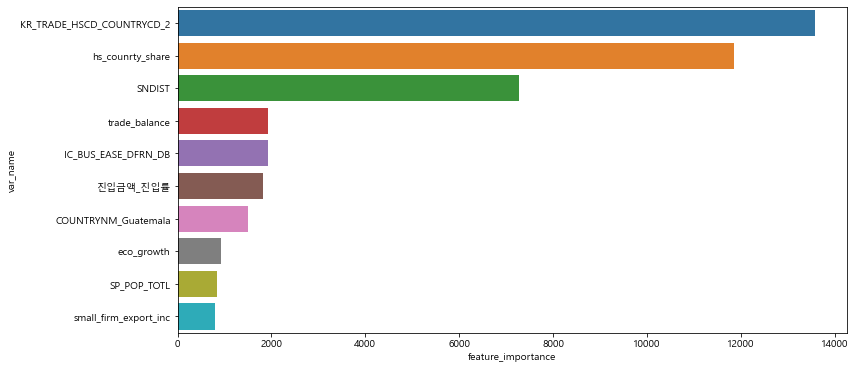

In [43]:
#1분위
varname = X_val_lgbm0.columns
varname = pd.DataFrame(varname, columns = ['var_name'])
feature_imp = model0.best_estimator_.feature_importances_
feature_imp = pd.DataFrame(feature_imp, columns = ['feature_importance'])
imp_graph_df = pd.concat([varname, feature_imp], axis = 1)
imp_graph_df = imp_graph_df.sort_values(by=['feature_importance'], ascending=False)
plt.figure(figsize = (12,6))
sns.barplot(data = imp_graph_df.iloc[:10,:], x = 'feature_importance', y = 'var_name')

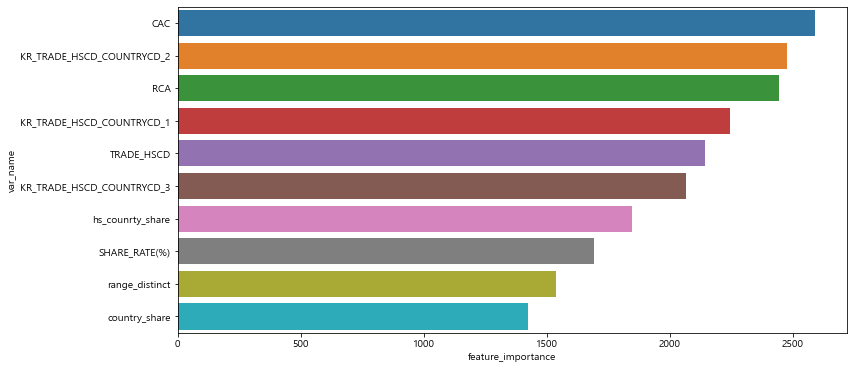

In [44]:
#2분위
varname = X_val_lgbm1.columns
varname = pd.DataFrame(varname, columns = ['var_name'])
feature_imp = model1.best_estimator_.feature_importances_
feature_imp = pd.DataFrame(feature_imp, columns = ['feature_importance'])
imp_graph_df = pd.concat([varname, feature_imp], axis = 1)
imp_graph_df = imp_graph_df.sort_values(by=['feature_importance'], ascending=False)
plt.figure(figsize = (12,6))
sns.barplot(data = imp_graph_df.iloc[:10,:], x = 'feature_importance', y = 'var_name')

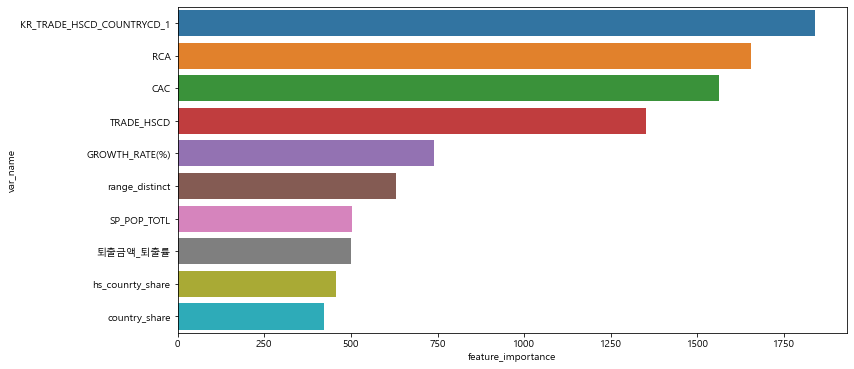

In [45]:
#3분위
varname = X_val_lgbm2.columns
varname = pd.DataFrame(varname, columns = ['var_name'])
feature_imp = model2.best_estimator_.feature_importances_
feature_imp = pd.DataFrame(feature_imp, columns = ['feature_importance'])
imp_graph_df = pd.concat([varname, feature_imp], axis = 1)
imp_graph_df = imp_graph_df.sort_values(by=['feature_importance'], ascending=False)
plt.figure(figsize = (12,6))
sns.barplot(data = imp_graph_df.iloc[:10,:], x = 'feature_importance', y = 'var_name')

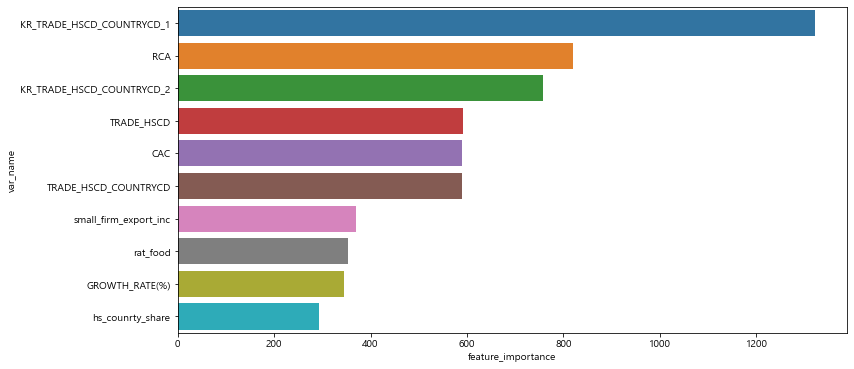

In [46]:
#4분위
varname = X_val_lgbm3.columns
varname = pd.DataFrame(varname, columns = ['var_name'])
feature_imp = model3.best_estimator_.feature_importances_
feature_imp = pd.DataFrame(feature_imp, columns = ['feature_importance'])
imp_graph_df = pd.concat([varname, feature_imp], axis = 1)
imp_graph_df = imp_graph_df.sort_values(by=['feature_importance'], ascending=False)
plt.figure(figsize = (12,6))
sns.barplot(data = imp_graph_df.iloc[:10,:], x = 'feature_importance', y = 'var_name')

### 변수의 영향 분석 - shap 값 분석

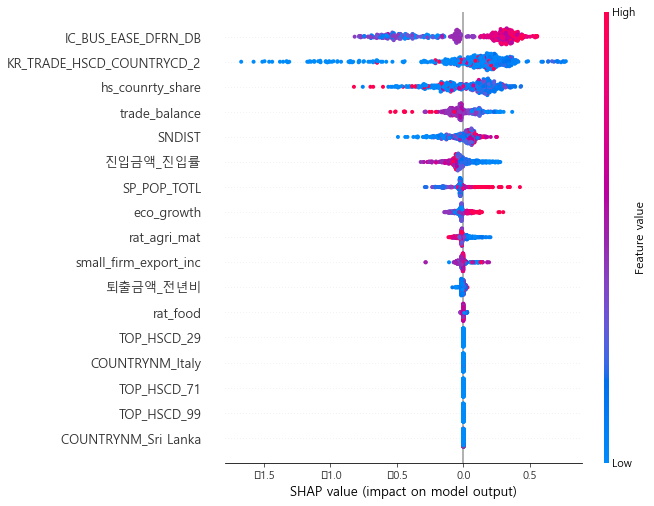

In [47]:
#1분위
model_shap0 = model0.best_estimator_
shap_values0 = shap.TreeExplainer(model_shap0).shap_values(X_val_lgbm0)
new_array = []
for i in range(len(shap_values0)):
    new_array.append(np.delete(shap_values0[i],0))
new_array = np.array(new_array)
shap.summary_plot(new_array, X_val_lgbm0.drop(columns = 'COUNTRYNM_Guatemala'))

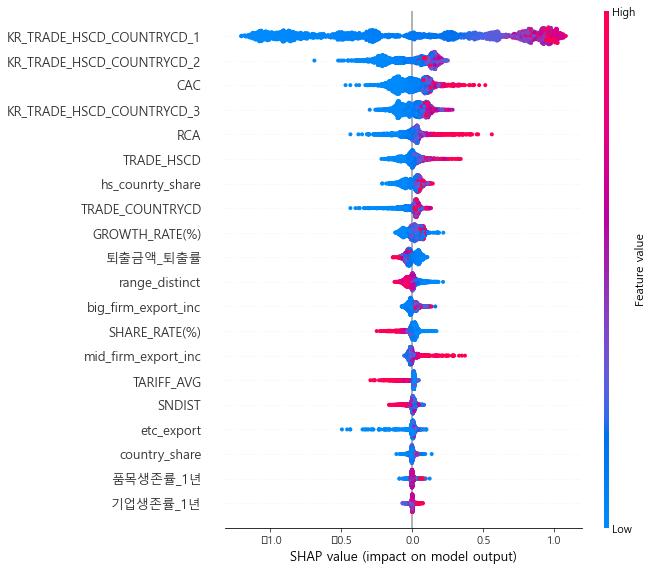

In [48]:
#2분위
model_shap1 = model1.best_estimator_
shap_values1 = shap.TreeExplainer(model_shap1).shap_values(X_val_lgbm1)
shap.summary_plot(shap_values1, X_val_lgbm1)

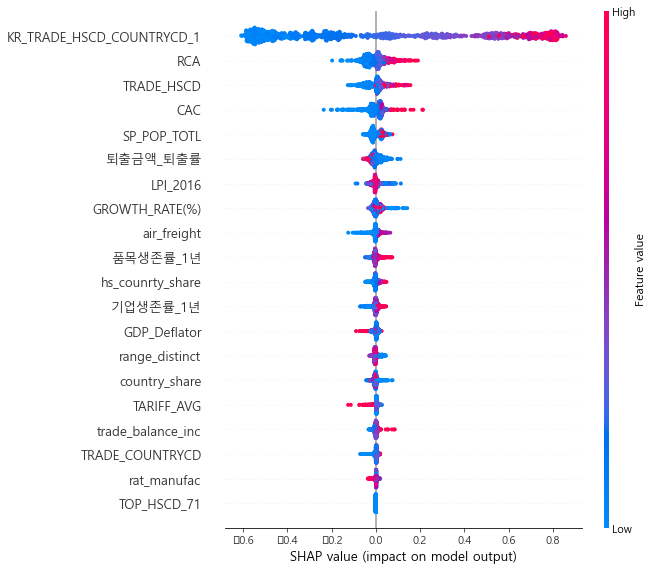

In [49]:
#3분위
model_shap2 = model2.best_estimator_
shap_values2 = shap.TreeExplainer(model_shap2).shap_values(X_val_lgbm2)
shap.summary_plot(shap_values2, X_val_lgbm2)

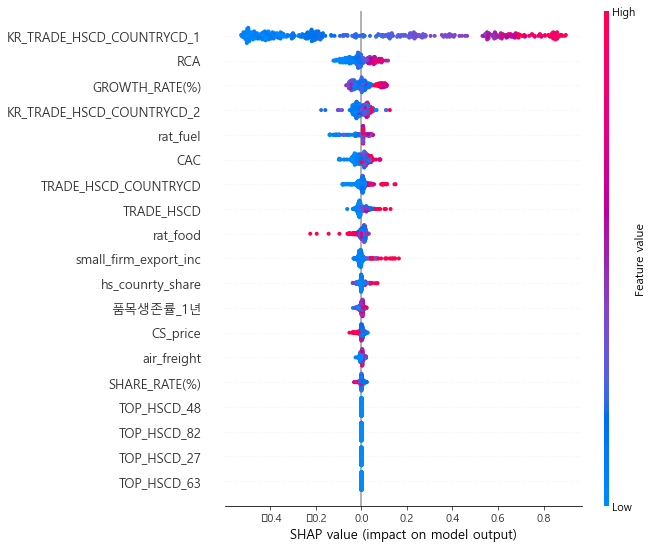

In [50]:
#4분위
model_shap3 = model3.best_estimator_
shap_values3 = shap.TreeExplainer(model_shap3).shap_values(X_val_lgbm3)
shap.summary_plot(shap_values3, X_val_lgbm3)

In [71]:
print('Validation_score')
get_score(y_val_lgbm0,y_val_lgbm1,y_val_lgbm2,y_val_lgbm3,y_val_lgbm4,pred_val_lgbm0,pred_val_lgbm1,pred_val_lgbm2,pred_val_lgbm3,pred_val_lgbm4)

Validation_score
---------0분위----------
MAE: 2268.6060277429256
RMSE: 3368.1767468351736


---------1분위----------
MAE: 108083.69576171215
RMSE: 167801.42897133582


---------2분위----------
MAE: 1100682.1377807157
RMSE: 1611359.3889704363


---------3분위----------
MAE: 8552013.33938055
RMSE: 13574801.049798537


---------4분위----------
MAE: 153690929.34756097
RMSE: 333217413.3175574


========Total========
MAE: 4097177.4113887544
RMSE: 46533099.35573663


### 제출파일 생성

In [70]:
#원 데이터 불러오기
raw_test = pd.read_csv('공모전데이터_예측용_KOTRA_0525.csv').drop(columns = 'KR_TRADE_HSCD_COUNTRYCD')

#COUNTRYNM, HSCD 와 예측값 결합
index = pd.concat([hs6_test_df_0,hs6_test_df_1,hs6_test_df_2,hs6_test_df_3,hs6_test_df_4], axis = 0).reset_index(drop = True).drop(columns = 'KR_TRADE_HSCD_COUNTRYCD')
pred_full = pd.DataFrame(np.concatenate([ np.expm1(pred_test_lgbm0),np.expm1(pred_test_lgbm1),np.expm1(pred_test_lgbm2),
                                         np.expm1(pred_test_lgbm3),pred_test_lgbm4]))
pred_full.columns = ['KR_TRADE_HSCD_COUNTRYCD']
merge_df = pd.concat([index[['HSCD','COUNTRYNM']], pred_full], axis = 1)

#최종 제출파일 생성
submission = pd.merge(raw_test, merge_df, on = ['HSCD','COUNTRYNM'], how = 'left')
submission.to_csv('submission.csv', index = False)

### 추천시스템

In [52]:
# raw test 생성
train_df = pd.read_csv('공모전데이터_분석용_KOTRA_0525.csv')
test_df = pd.read_csv('공모전데이터_예측용_KOTRA_0525.csv')

train_df = insert_columns(train_df, 2017)
test_df = insert_columns(test_df, 2018)

train_df, test_df = fillna_train_test(train_df, test_df)

make_variables(test_df)

In [104]:
# 제출파일 불러오기
submission = pd.read_csv('submission.csv')

#최종 제출파일 생성
raw_test = test_df.drop(columns=['KR_TRADE_HSCD_COUNTRYCD'])
submission = pd.merge(raw_test, submission[['HSCD', 'COUNTRYNM', 'KR_TRADE_HSCD_COUNTRYCD']], on = ['HSCD','COUNTRYNM'], how = 'left')

In [105]:
# 과거 종속변수 추가
submission['KR_TRADE_HSCD_COUNTRYCD_18'] = train_df['KR_TRADE_HSCD_COUNTRYCD']

# 증감률, 점유율 추가
submission['GROWTH_RATE'] = (submission['KR_TRADE_HSCD_COUNTRYCD'] - submission['KR_TRADE_HSCD_COUNTRYCD_18']) / submission['KR_TRADE_HSCD_COUNTRYCD_18'] * 100
submission["SHARE_RATE"] = submission["KR_TRADE_HSCD_COUNTRYCD_18"] / submission['TRADE_HSCD_COUNTRYCD'] * 100

#### 대시보드 생성

In [106]:
def show_export(df):
    plt.figure(figsize=(20,8))
    #plt.title(f"[{hs_code}] 2018, 2019년도 대한국 수입액", fontsize=20, fontweight='bold')
    bins = np.arange(len(df['COUNTRYNM']))
    plt.bar(bins, df['KR_TRADE_HSCD_COUNTRYCD'], 0.4, label="2019", color='coral')

    for v in bins :
        plt.text(v, df['KR_TRADE_HSCD_COUNTRYCD'][v], df['KR_TRADE_HSCD_COUNTRYCD'][v].astype('int'),
                 color='black',
                 horizontalalignment='center',  # horizontalalignment (left, center, right)
                 verticalalignment='bottom',
                 fontsize=15)    # verticalalignment (top, center, bottom)
    plt.bar(bins-0.4, df['KR_TRADE_HSCD_COUNTRYCD_18'], 0.4,label="2018", color='teal')

    for v in bins :
        plt.text(v-0.4, df['KR_TRADE_HSCD_COUNTRYCD_18'][v], df['KR_TRADE_HSCD_COUNTRYCD_18'][v],
                 color='black',
                 horizontalalignment='center',  # horizontalalignment (left, center, right)
                 verticalalignment='bottom',
                 fontsize=15)    # verticalalignment (top, center, bottom)
    plt.xticks(bins-0.2, list(df['COUNTRYNM'].values),fontsize=20,rotation=0)
    plt.yticks(fontsize=15)
    plt.ticklabel_format(style='plain', axis='y')
    plt.legend(fontsize=15, markerscale=3)
    plt.show()

In [107]:
def show_firm_info(df):
    plt.figure(figsize=(20,8))
    #plt.title(f"[{hs_code}] 2018년 활동, 진입, 퇴출 기업 ", fontsize=20, fontweight='bold')
    bins = np.arange(len(df['COUNTRYNM']))

    
    plt.bar(bins-0.6, df['활동기업'], 0.3, label="활동기업", color='mediumslateblue')
    for v in bins :
        plt.text(v-0.6, df['활동기업'][v], df['활동기업'][v].astype('int'),
                 color='black',
                 horizontalalignment='center',  # horizontalalignment (left, center, right)
                 verticalalignment='bottom',
                 fontsize=15)    # verticalalignment (top, center, bottom)

    plt.bar(bins-0.3, df['진입기업'], 0.3,label="진입기업", color='wheat')
    for v in bins :
        plt.text(v-0.3, df['진입기업'][v], df['진입기업'][v].astype('int'),
                 color='black',
                 horizontalalignment='center',  # horizontalalignment (left, center, right)
                 verticalalignment='bottom',
                 fontsize=15)    # verticalalignment (top, center, bottom)

    plt.bar(bins, df['퇴출기업'], 0.3,label="퇴출기업", color='tomato')
    for v in bins :
        plt.text(v, df['퇴출기업'][v], df['퇴출기업'][v].astype('int'),
                 color='black',
                 horizontalalignment='center',  # horizontalalignment (left, center, right)
                 verticalalignment='bottom',
                 fontsize=15)    # verticalalignment (top, center, bottom)
    plt.xticks(bins-0.3, list(df['COUNTRYNM'].values),fontsize=20,rotation=0)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=15, markerscale=3)
    plt.show()

In [108]:
def show_bcg(df, name_list):
    df.loc[df['GROWTH_RATE'] > df['GROWTH_RATE'].iloc[10], 'top_10'] = "TOP_10"
    df['top_10'] = df['top_10'].fillna("Others")

    name_list = df['COUNTRYNM']
    df["SHARE_RATE(%)_log"] = np.log1p(df['SHARE_RATE'])
    fig = plt.figure(figsize=(20,10))

    ax1 = fig.add_subplot(111)
    #plt.title(f"[{hs_code}] BCG MATRIX", fontsize=20, fontweight='bold')
    plt.xlabel("GROWTH_RATE(%)", fontsize=25)
    plt.ylabel("SHARE_RATE(%)_log", fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    sns.scatterplot(x = df["GROWTH_RATE"], y = df["SHARE_RATE(%)_log"], hue=df['top_10'],  
                    s=200, palette=['red','lightblue'], zorder=2)
    ax1.axvline(x = 0, color='gray', linewidth=3, zorder=1)
    ax1.axhline(y = 1, color='gray', linewidth=3, zorder=1)
    if len(name_list) > 1 :
        for i, label in enumerate(name_list):
            plt.text(df["GROWTH_RATE"].iloc[i], df["SHARE_RATE(%)_log"].iloc[i],label, fontsize=20)
    plt.legend(fontsize=15, markerscale=3)

    plt.show()

In [119]:
def show_cac_table(df, name_list):
    df.loc[df['GROWTH_RATE'] > df['GROWTH_RATE'].iloc[10], 'top_10'] = "TOP_10"
    df['top_10'] = df['top_10'].fillna("Others")
    df.loc[df["CAC"] > 5, 'CAC'] = 5
    name_list = df['COUNTRYNM']
    fig = plt.figure(figsize=(20,10))

    ax1 = fig.add_subplot(111)
    #plt.title(f"[{hs_code}] BCG MATRIX", fontsize=20, fontweight='bold')
    plt.ticklabel_format(style='plain', axis='y')
    plt.xlabel("CAC", fontsize=25)
    plt.ylabel("TRADE_COUNTRYCD", fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=15)
    sns.scatterplot(x = df["CAC"], y = df["TRADE_COUNTRYCD"], hue=df['top_10'],  
                    s=200, palette=['blue','bisque'], zorder=2)
    ax1.axvline(x = 0, color='gray', linewidth=3, zorder=1)
    if len(name_list) > 1 :
        for i, label in enumerate(name_list):
            plt.text(df["CAC"].iloc[i], df["TRADE_COUNTRYCD"].iloc[i],label, fontsize=20)
    plt.legend(fontsize=15, markerscale=3)
    plt.show()

In [120]:
from IPython.display import display
def export_promising_country(hs_code):
    # groupby 분리
    one_hs_df = submission.groupby('HSCD').get_group(hs_code)
    
    # inf값 제거
    one_hs_df = one_hs_df[one_hs_df['GROWTH_RATE'] != np.inf]
    
    # 품목 관련 정보 
    hs_info = one_hs_df[['RCA', '품목생존률_1년', '품목생존률_5년', 'TRADE_HSCD']][:1].transpose().reset_index()
    hs_info.columns = ["변수", "값"]
    hs_info['단위'] = ['index', '%', '%', '$']
    display(hs_info)
    
    # 수출증감율 상위 10개 국가만 선정
    one_hs_df = one_hs_df.sort_values(['GROWTH_RATE'], ascending=False)
    one_hs_df_top_10 = one_hs_df.iloc[:5].reset_index(drop=True)
    
    hs_list = one_hs_df_top_10['COUNTRYNM']
    show_export(one_hs_df_top_10)
    show_firm_info(one_hs_df_top_10)
    show_bcg(one_hs_df, hs_list)
    show_cac_table(one_hs_df, hs_list)

,변수,값,단위
0,RCA,0.151,index
1,품목생존률_1년,41.000,%
2,품목생존률_5년,11.300,%
3,TRADE_HSCD,2801885194.000,$


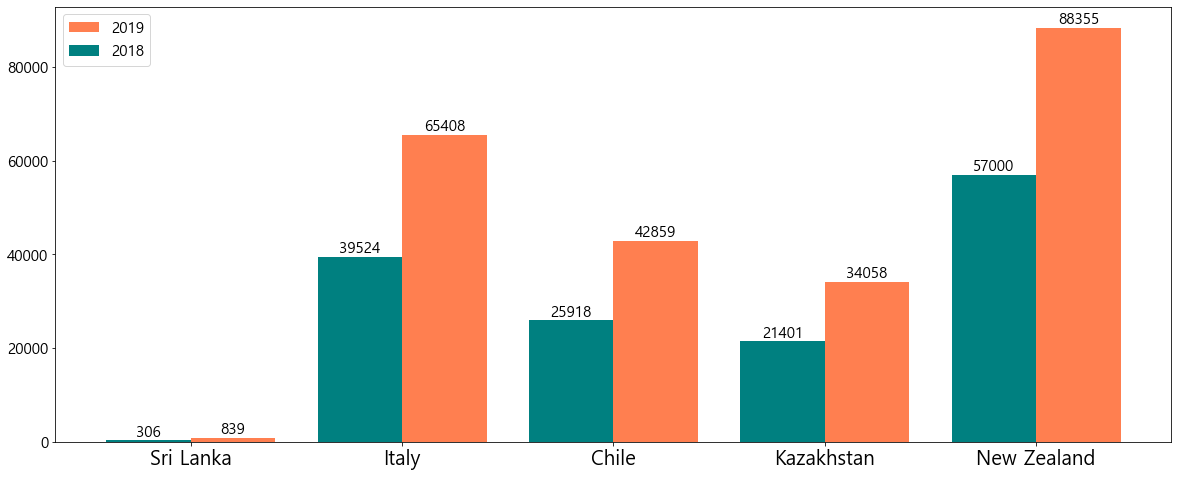

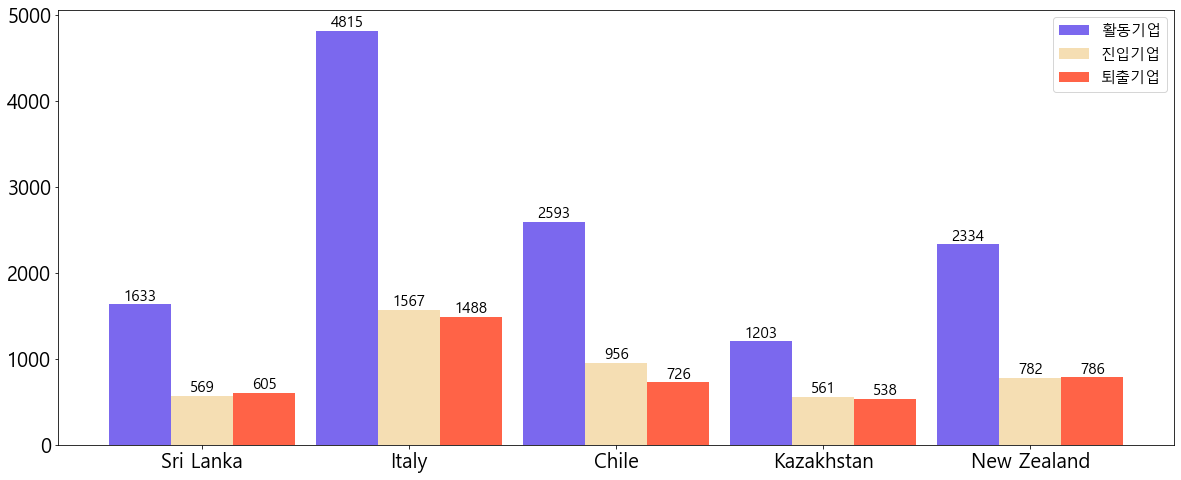

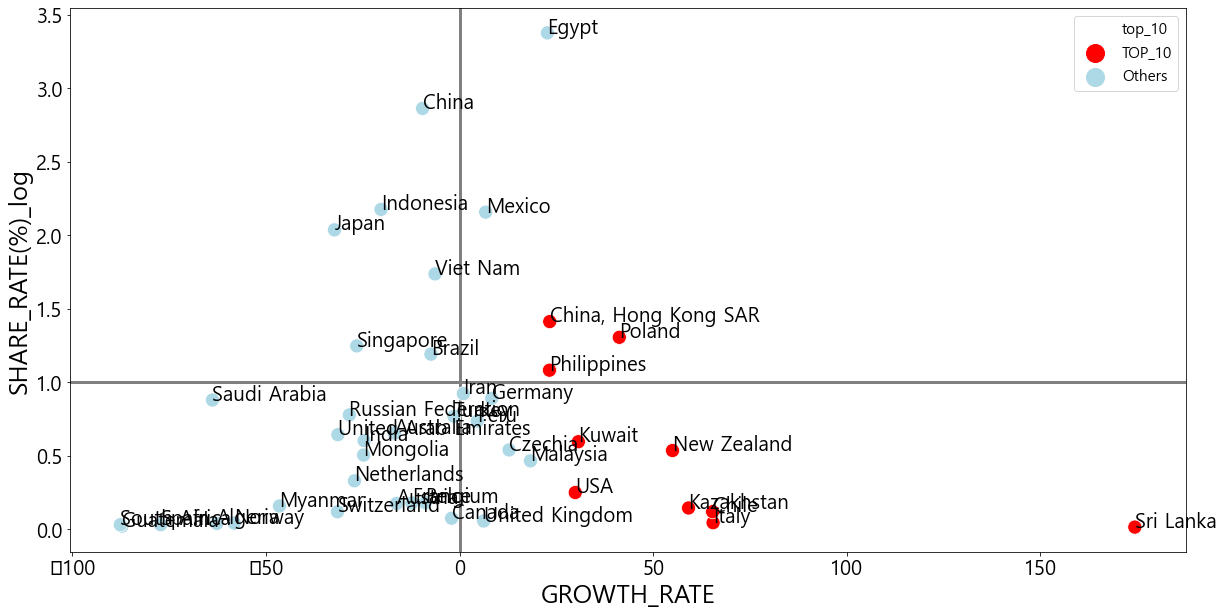

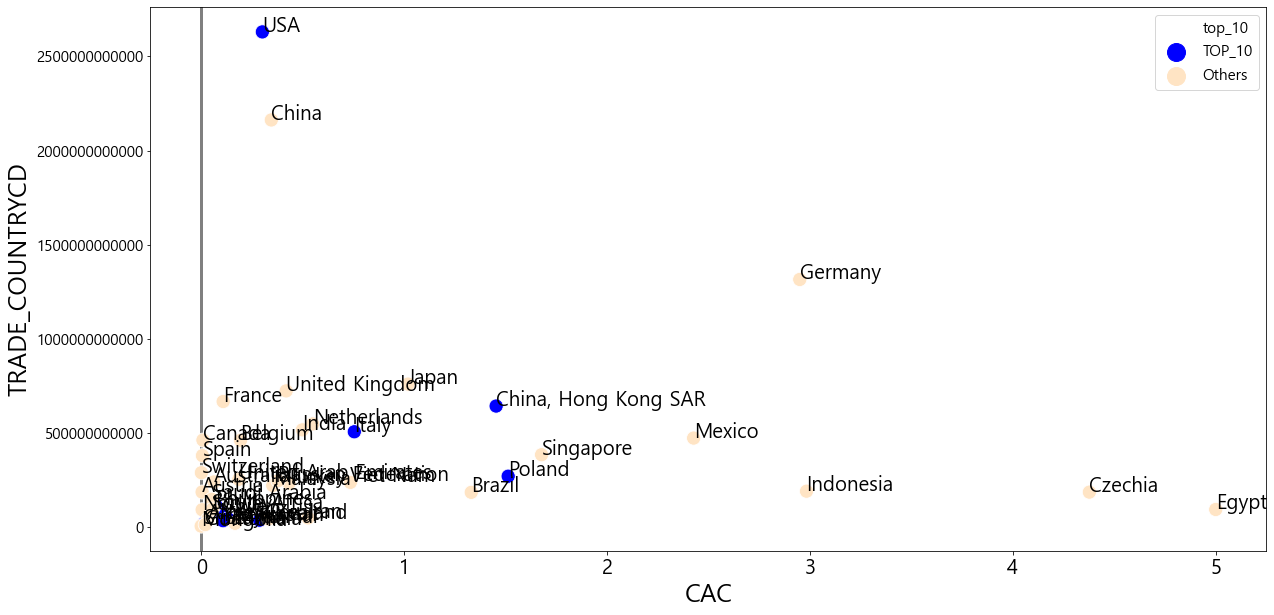

In [121]:
# input hs code
export_promising_country(591190)